# Genetic Risk Profiling

## Overview

The objective of this notebook is to cluster patients based on their genetic data to identify groups with similar genetic profiles.

## Dataset Information
Kaggle Dataset Link: https://www.kaggle.com/datasets/aibuzz/predict-the-genetic-disorders-datasetof-genomes/data

The dataset was curated by Amit Kumar and posted on Kaggle. It has been divided into train and test. For our case study, we will only work with the train dataset.


## Dataset Schema
| Column name                                    | Column description                                                                 |
|------------------------------------------------|-------------------------------------------------------------------------------------|
| Patient Id                                     | Represents the unique identification number of a patient                            |
| Patient Age                                    | Represents the age of a patient                                                     |
| Genes in mother's side                         | Represents a gene defect in a patient's mother                                      |
| Inherited from father                          | Represents a gene defect in a patient's father                                      |
| Maternal gene                                  | Represents a gene defect in the patient's maternal side of the family               |
| Paternal gene                                  | Represents a gene defect in a patient's paternal side of the family                 |
| Blood cell count (mcL)                         | Represents the blood cell count of a patient                                        |
| Patient First Name                             | Represents a patient's first name                                                   |
| Family Name                                    | Represents a patient's family name or surname                                       |
| Father's name                                  | Represents a patient's father's name                                                |
| Mother's age                                   | Represents a patient's mother's name                                                |
| Father's age                                   | Represents a patient's father's age                                                 |
| Institute Name                                 | Represents the medical institute where a patient was born                           |
| Location of Institute                          | Represents the location of the medical institute                                    |
| Status                                         | Represents whether a patient is deceased                                            |
| Respiratory Rate (breaths/min)                 | Represents a patient's respiratory breathing rate                                   |
| Heart Rate (rates/min)                         | Represents a patient's heart rate                                                   |
| Test 1 - Test 5                                | Represents different (masked) tests that were conducted on a patient                |
| Parental consent                               | Represents whether a patient's parents approved the treatment plan                  |
| Follow-up                                      | Represents a patient's level of risk (how intense their condition is)               |
| Gender                                         | Represents a patient's gender                                                       |
| Birth asphyxia                                 | Represents whether a patient suffered from birth asphyxia                           |
| Autopsy shows birth defect (if applicable)     | Represents whether a patient's autopsy showed any birth defects                     |
| Place of birth                                 | Represents whether a patient was born in a medical institute or home                |
| Folic acid details (peri-conceptional)         | Represents the periconceptional folic acid supplementation details of a patient     |
| H/O serious maternal illness                   | Represents an unexpected outcome of labor and delivery that resulted in significant short or long-term consequences to a patient's mother |
| H/O radiation exposure (x-ray)                 | Represents whether a patient has any radiation exposure history                     |
| H/O substance abuse                            | Represents whether a parent has a history of drug addiction                         |
| Assisted conception IVF/ART                    | Represents the type of treatment used for infertility                               |
| History of anomalies in previous pregnancies   | Represents whether the mother had any anomalies in her previous pregnancies         |
| No. of previous abortion                       | Represents the number of abortions that a mother had                                |
| Birth defects                                  | Represents whether a patient has birth defects                                      |
| White Blood cell count (thousand per microliter) | Represents a patient's white blood cell count                                      |
| Blood test result                              | Represents a patient's blood test results                                           |
| Symptom 1 - Symptom 5                          | Represents (masked) different types of symptoms that a patient had                  |
| Genetic Disorder                               | Represents the genetic disorder that a patient has                                  |
| Disorder Subclass                              | Represents the subclass of the disorder                                             |



## Libraries

In [113]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.cm as cm
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

pd.options.display.max_colwidth = 100
pd.set_option('display.max_columns', None)

from numpy.random import seed
seed(42)

import math

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans, SpectralClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.base import clone
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')


## Data

In [4]:
df = pd.read_csv('../Data/genetic_genome/train_genetic_disorders.csv')
df.head()

Patient Id  Patient Age Genes in mother's side Inherited from father  \
0  PID0x6418          2.0                    Yes                    No   
1  PID0x25d5          4.0                    Yes                   Yes   
2  PID0x4a82          6.0                    Yes                    No   
3  PID0x4ac8         12.0                    Yes                    No   
4  PID0x1bf7         11.0                    Yes                    No   

  Maternal gene Paternal gene  Blood cell count (mcL) Patient First Name  \
0           Yes            No                4.760603            Richard   
1            No            No                4.910669               Mike   
2            No            No                4.893297           Kimberly   
3           Yes            No                4.705280            Jeffery   
4           NaN           Yes                4.720703            Johanna   

  Family Name Father's name  Mother's age  Father's age  \
0         NaN         Larre           NaN           NaN   
1         NaN        Brycen           NaN          23.0   
2         NaN        Nashon          41.0          22.0   
3   Hoelscher        Aayaan          21.0           NaN   
4    Stutzman         Suave          32.0           NaN   

                               Institute Name  \
0  Boston Specialty & Rehabilitation Hospital   
1           St. Margaret's Hospital For Women   
2                                         NaN   
3                                         NaN   
4                             Carney Hospital   

                                                                       Location of Institute  \
0                    55 FRUIT ST\nCENTRAL, MA 02114\n(42.36247485742686, -71.06924724545246)   
1  1515 COMMONWEALTH AV\nALLSTON/BRIGHTON, MA 02135\n(42.34665771451756, -71.14136122385321)   
2                                                                                          -   
3                    55 FRUIT ST\nCENTRAL, MA 02114\n(42.36247485742686, -71.06924724545246)   
4        300 LONGWOOD AV\nFENWAY/KENMORE, MA 02115\n(42.337592548462226, -71.10472284437952)   

     Status Respiratory Rate (breaths/min) Heart Rate (rates/min  Test 1  \
0     Alive                 Normal (30-60)                Normal     0.0   
1  Deceased                      Tachypnea                Normal     NaN   
2     Alive                 Normal (30-60)           Tachycardia     0.0   
3  Deceased                      Tachypnea                Normal     0.0   
4     Alive                      Tachypnea           Tachycardia     0.0   

   Test 2  Test 3  Test 4  Test 5 Parental consent Follow-up Gender  \
0     NaN     NaN     1.0     0.0              Yes      High    NaN   
1     0.0     0.0     1.0     0.0              Yes      High    NaN   
2     0.0     0.0     1.0     0.0              Yes       Low    NaN   
3     0.0     0.0     1.0     0.0              Yes      High   Male   
4     0.0     0.0     1.0     0.0              NaN       Low   Male   

  Birth asphyxia Autopsy shows birth defect (if applicable) Place of birth  \
0            NaN                             Not applicable      Institute   
1             No                                        NaN            NaN   
2      No record                             Not applicable            NaN   
3  Not available                                         No      Institute   
4  Not available                             Not applicable      Institute   

  Folic acid details (peri-conceptional) H/O serious maternal illness  \
0                                     No                          NaN   
1                                    Yes                          Yes   
2                                    Yes                           No   
3                                     No                          Yes   
4                                     No                          Yes   

  H/O radiation exposure (x-ray) H/O substance abuse  \
0                        

## Exploratory Data Analysis

In [5]:
df.columns

Index(['Patient Id', 'Patient Age', 'Genes in mother's side',
       'Inherited from father', 'Maternal gene', 'Paternal gene',
       'Blood cell count (mcL)', 'Patient First Name', 'Family Name',
       'Father's name', 'Mother's age', 'Father's age', 'Institute Name',
       'Location of Institute', 'Status', 'Respiratory Rate (breaths/min)',
       'Heart Rate (rates/min', 'Test 1', 'Test 2', 'Test 3', 'Test 4',
       'Test 5', 'Parental consent', 'Follow-up', 'Gender', 'Birth asphyxia',
       'Autopsy shows birth defect (if applicable)', 'Place of birth',
       'Folic acid details (peri-conceptional)',
       'H/O serious maternal illness', 'H/O radiation exposure (x-ray)',
       'H/O substance abuse', 'Assisted conception IVF/ART',
       'History of anomalies in previous pregnancies',
       'No. of previous abortion', 'Birth defects',
       'White Blood cell count (thousand per microliter)', 'Blood test result',
       'Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'S

In [6]:
df.shape

(22083, 45)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22083 entries, 0 to 22082
Data columns (total 45 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Patient Id                                        21011 non-null  object 
 1   Patient Age                                       19643 non-null  float64
 2   Genes in mother's side                            21011 non-null  object 
 3   Inherited from father                             20724 non-null  object 
 4   Maternal gene                                     18317 non-null  object 
 5   Paternal gene                                     21011 non-null  object 
 6   Blood cell count (mcL)                            21011 non-null  float64
 7   Patient First Name                                21011 non-null  object 
 8   Family Name                                       11771 non-null  object 
 9   Father's name    

In [8]:
# Dropping the features
df.drop(columns=[
    'Patient Id','Patient First Name','Family Name','Father\'s name','Institute Name',
    'Location of Institute','Parental consent'], 
    axis=1, inplace=True)

In [9]:
df=df.rename(columns={
    "Genes in mother's side":'defective_mother',
    'Inherited from father':'defective_father',
    'Maternal gene':'maternal_gene',
    'Paternal gene':'paternal_gene',
    'Respiratory Rate (breaths/min)':'respiratory_rate',
    'Heart Rate (rates/min':'heart_rate',
    'Parental consent':'parental_consent',
    'Follow-up':'follow_up',
    'Birth asphyxia':'birth_asphyxia',
    'Autopsy shows birth defect (if applicable)':'birth_defect_autopsy',
    'Place of birth':'birth_place',
    'Folic acid details (peri-conceptional)':'folic_acid_periconceptional',
    'H/O serious maternal illness':'maternal_illness',
    'H/O radiation exposure (x-ray)':'radiation_exposure',
    'H/O substance abuse':'substance_abuse',
    'Assisted conception IVF/ART':'assisted_conception',
    'History of anomalies in previous pregnancies':'previous_pregnancy_anomalies',
    'Birth defects':'birth_defects',
    'Blood test result':'blood_test_result',
    'Genetic Disorder':'genetic_disorder',
    'Disorder Subclass':'disorder_subclass',
    'Patient Age':'patient_age',
    'Blood cell count (mcL)':'blood_cell_count',
    "Mother's age":'mother_age',
    "Father's age":'father_age',
    'No. of previous abortion':'num_previous_abortion',
    'White Blood cell count (thousand per microliter)':'WBC_count'
})

In [10]:
df.select_dtypes(exclude = 'object').describe()

patient_age  blood_cell_count    mother_age    father_age   Test 1  \
count  19643.000000      21011.000000  15293.000000  15322.000000  18992.0   
mean       6.974851          4.899004     34.522527     41.942436      0.0   
std        4.322584          0.199829      9.847256     13.027701      0.0   
min        0.000000          4.092727     18.000000     20.000000      0.0   
25%        3.000000          4.763230     26.000000     31.000000      0.0   
50%        7.000000          4.899548     35.000000     42.000000      0.0   
75%       11.000000          5.033977     43.000000     53.000000      0.0   
max       14.000000          5.609829     51.000000     64.000000      0.0   

        Test 2   Test 3   Test 4   Test 5  num_previous_abortion  \
count  18958.0  18970.0  18962.0  18939.0           18957.000000   
mean       0.0      0.0      1.0      0.0               2.000106   
std        0.0      0.0      0.0      0.0               1.411488   
min        0.0      0.0      1.0      0.0               0.000000   
25%        0.0      0.0      1.0      0.0               1.000000   
50%        0.0      0.0      1.0      0.0               2.000000   
75%        0.0      0.0      1.0      0.0               3.000000   
max        0.0      0.0      1.0      0.0               4.000000   

          WBC_count     Symptom 1     Symptom 2     Symptom 3     Symptom 4  \
count  18965.000000  18955.000000  18899.000000  19008.000000  18987.000000   
mean       7.484680      0.592034      0.552886      0.537405      0.497393   
std        2.653633      0.491470      0.497208      0.498612      0.500006   
min        3.000000      0.000000      0.000000      0.000000      0.000000   
25%        5.419026      0.000000      0.000000      0.000000      0.000000   
50%        7.473071      1.000000      1.000000      1.000000      0.000000   
75%        9.528684      1.000000      1.000000      1.000000      1.000000   
max       12.000000      1.000000      1.000000      1.000000      1.000000   

          Symptom 5  
count  18956.000000  
mean       0.460804  
std        0.498474  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        1.000000

In [11]:
df.select_dtypes(include = 'object').describe()

defective_mother defective_father maternal_gene paternal_gene Status  \
count             21011            20724         18317         21011  21011   
unique                2                2             2             2      2   
top                 Yes               No           Yes            No  Alive   
freq              12509            12508         10125         11887  10572   

       respiratory_rate heart_rate follow_up     Gender birth_asphyxia  \
count             18952      18986     18941      18948          18953   
unique                2          2         2          3              4   
top      Normal (30-60)     Normal       Low  Ambiguous            Yes   
freq               9595       9715      9564       6385           4839   

       birth_defect_autopsy birth_place folic_acid_periconceptional  \
count                 16847       18993                       18998   
unique                    3           2                           2   
top          Not applicable   Institute                         Yes   
freq                  10572        9591                        9625   

       maternal_illness radiation_exposure substance_abuse  \
count             18959              18964           18921   
unique                2                  4               4   
top                  No     Not applicable               -   
freq               9500               4807            4797   

       assisted_conception previous_pregnancy_anomalies birth_defects  \
count                19007                        18945         18959   
unique                   2                            2             2   
top                    Yes                          Yes      Singular   
freq                  9555                         9605          9509   

        blood_test_result                             genetic_disorder  \
count               18977                                        18962   
unique                  4                                            3   
top     slightly abnormal  Mitochondrial genetic inheritance disorders   
freq                 4855                                         9686   

       disorder_subclass  
count              18943  
unique                 9  
top       Leigh syndrome  
freq                4893

In [12]:
# checking for count of duplicate records
df.duplicated().sum()

np.int64(1071)

In [13]:
# dropping duplicate records
df.drop_duplicates(inplace=True)

In [14]:
df.isnull().sum()

patient_age                     1369
defective_mother                   1
defective_father                 288
maternal_gene                   2695
paternal_gene                      1
blood_cell_count                   1
mother_age                      5719
father_age                      5690
Status                             1
respiratory_rate                2060
heart_rate                      2026
Test 1                          2020
Test 2                          2054
Test 3                          2042
Test 4                          2050
Test 5                          2073
follow_up                       2071
Gender                          2064
birth_asphyxia                  2059
birth_defect_autopsy            4165
birth_place                     2019
folic_acid_periconceptional     2014
maternal_illness                2053
radiation_exposure              2048
substance_abuse                 2091
assisted_conception             2005
previous_pregnancy_anomalies    2067
n

In [15]:
# percentage of missing values
percentage_missing = df.isnull().sum() / df.shape[0] * 100
percentage_missing

patient_age                      6.515325
defective_mother                 0.004759
defective_father                 1.370645
maternal_gene                   12.826004
paternal_gene                    0.004759
blood_cell_count                 0.004759
mother_age                      27.217780
father_age                      27.079764
Status                           0.004759
respiratory_rate                 9.803922
heart_rate                       9.642109
Test 1                           9.613554
Test 2                           9.775366
Test 3                           9.718256
Test 4                           9.756330
Test 5                           9.865791
follow_up                        9.856273
Gender                           9.822958
birth_asphyxia                   9.799162
birth_defect_autopsy            19.822006
birth_place                      9.608795
folic_acid_periconceptional      9.584999
maternal_illness                 9.770607
radiation_exposure               9

Genetic Disorder and Discorder subclass can be used for evaluating clusters

In [16]:
df['genetic_disorder'].unique()

array(['Mitochondrial genetic inheritance disorders', nan,
       'Multifactorial genetic inheritance disorders',
       'Single-gene inheritance diseases'], dtype=object)

In [17]:
df['disorder_subclass'].unique()

array(["Leber's hereditary optic neuropathy", 'Cystic fibrosis',
       'Diabetes', 'Leigh syndrome', 'Cancer', 'Tay-Sachs',
       'Hemochromatosis', 'Mitochondrial myopathy', nan, "Alzheimer's"],
      dtype=object)

In [18]:
len(df['disorder_subclass'].unique())

10

In [19]:
# removing rows were disorder_subclass is nan
df=df[(df['genetic_disorder'].isnull()!=True)&(df['disorder_subclass'].isnull()!=True)]
df.shape

(17160, 38)

In [20]:
df[['genetic_disorder','disorder_subclass']].isnull().sum()

genetic_disorder     0
disorder_subclass    0
dtype: int64

In [21]:
# printing the unique values of all columns
for col in df.columns:
    print(f"{col}: {df[col].unique()}")

patient_age: [ 2.  6. 12. 11. 14.  3.  4.  7.  1.  0. nan 10.  5.  8.  9. 13.]
defective_mother: ['Yes' 'No']
defective_father: ['No' 'Yes' nan]
maternal_gene: ['Yes' 'No' nan]
paternal_gene: ['No' 'Yes']
blood_cell_count: [4.76060309 4.89329743 4.70528039 ... 5.21475028 5.22482777 5.13794212]
mother_age: [nan 41. 21. 32. 40. 45. 44. 50. 30. 24. 36. 51. 23. 49. 46. 18. 38. 37.
 42. 48. 28. 25. 19. 47. 34. 35. 22. 33. 20. 29. 26. 31. 27. 43. 39.]
father_age: [nan 22. 63. 44. 42. 56. 20. 24. 57. 48. 30. 55. 62. 32. 41. 52. 28. 31.
 61. 35. 49. 50. 23. 29. 64. 39. 34. 51. 25. 43. 60. 53. 58. 26. 27. 59.
 38. 47. 54. 21. 37. 36. 46. 40. 45. 33.]
Status: ['Alive' 'Deceased']
respiratory_rate: ['Normal (30-60)' 'Tachypnea' nan]
heart_rate: ['Normal' 'Tachycardia' nan]
Test 1: [ 0. nan]
Test 2: [nan  0.]
Test 3: [nan  0.]
Test 4: [ 1. nan]
Test 5: [ 0. nan]
follow_up: ['High' 'Low' nan]
Gender: [nan 'Male' 'Female' 'Ambiguous']
birth_asphyxia: [nan 'No record' 'Not available' 'Yes' 'No']
birt

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17160 entries, 0 to 21010
Data columns (total 38 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_age                   16146 non-null  float64
 1   defective_mother              17160 non-null  object 
 2   defective_father              16954 non-null  object 
 3   maternal_gene                 15171 non-null  object 
 4   paternal_gene                 17160 non-null  object 
 5   blood_cell_count              17160 non-null  float64
 6   mother_age                    12943 non-null  float64
 7   father_age                    12969 non-null  float64
 8   Status                        17160 non-null  object 
 9   respiratory_rate              15654 non-null  object 
 10  heart_rate                    15697 non-null  object 
 11  Test 1                        15662 non-null  float64
 12  Test 2                        15643 non-null  float64
 13  Test 3

In [23]:
# check all null rows
df.isnull().any(axis=1).sum()

np.int64(11799)

In [24]:
tests = ['Test 1','Test 2','Test 3','Test 4','Test 5']
for col in tests:
    print(col,":\n",df[col].unique())

Test 1 :
 [ 0. nan]
Test 2 :
 [nan  0.]
Test 3 :
 [nan  0.]
Test 4 :
 [ 1. nan]
Test 5 :
 [ 0. nan]


In [25]:
# Dropping Test 1-5
df.drop(columns=tests, axis=1, inplace=True)

<Axes: xlabel='mother_age', ylabel='Density'>

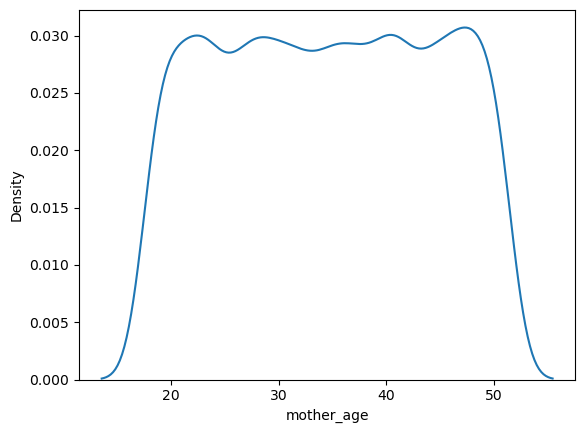

In [26]:
sns.kdeplot(df['mother_age'])

<Axes: xlabel='father_age', ylabel='Density'>

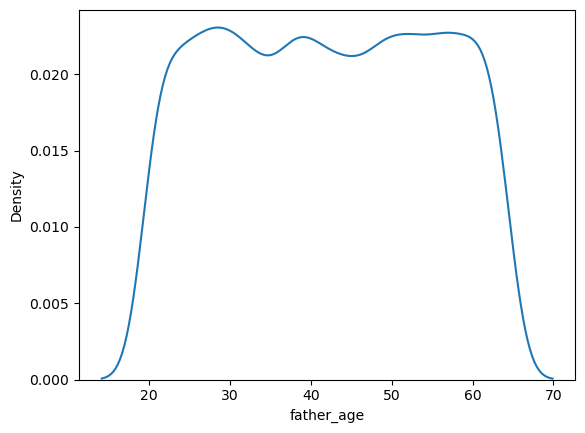

In [27]:
sns.kdeplot(df['father_age'])

In [28]:
parent_age = ["mother_age", "father_age"]
df[parent_age] = df[parent_age].fillna(np.floor(df[parent_age].mean()))

In [29]:
np.floor(df[parent_age].mean())

mother_age    34.0
father_age    41.0
dtype: float64

In [30]:
df.shape

(17160, 33)

In [31]:
len(df['Symptom 1'].unique())

3

In [32]:
numerical_features = [feature for feature in df.columns if len(df[feature].unique()) > 10]
categorical_features = [feature for feature in df.columns if len(df[feature].unique()) < 10]
len(numerical_features), len(categorical_features)

(5, 28)

In [33]:
df[numerical_features].describe().T

count       mean        std       min        25%  \
patient_age       16146.0   6.945683   4.318286   0.00000   3.000000   
blood_cell_count  17160.0   4.899434   0.199192   4.14623   4.764297   
mother_age        17160.0  34.430536   8.526641  18.00000  29.000000   
father_age        17160.0  41.726515  11.351844  20.00000  34.000000   
WBC_count         15626.0   7.470663   2.650636   3.00000   5.417074   

                        50%        75%        max  
patient_age        7.000000  11.000000  14.000000  
blood_cell_count   4.900514   5.033921   5.609829  
mother_age        34.000000  40.000000  51.000000  
father_age        41.000000  50.000000  64.000000  
WBC_count          7.461071   9.515633  12.000000

In [34]:
# Define imputers
imp_mode = SimpleImputer(strategy='most_frequent')
imp_median = SimpleImputer(strategy='median')

# Loop over columns
for col in df.columns:
    if df[col].dtype != "object" and df[col].nunique() <= 3:
        # Numeric with few unique values → use mode
        df[col] = imp_mode.fit_transform(df[[col]]).ravel()
    
    elif df[col].dtype != "object" and df[col].nunique() > 3:
        # Continuous numeric → use median
        df[col] = imp_median.fit_transform(df[[col]]).ravel()
    
    else:
        # Categorical → use mode
        df[col] = imp_mode.fit_transform(df[[col]]).ravel()

In [35]:
df.isna().sum()

patient_age                     0
defective_mother                0
defective_father                0
maternal_gene                   0
paternal_gene                   0
blood_cell_count                0
mother_age                      0
father_age                      0
Status                          0
respiratory_rate                0
heart_rate                      0
follow_up                       0
Gender                          0
birth_asphyxia                  0
birth_defect_autopsy            0
birth_place                     0
folic_acid_periconceptional     0
maternal_illness                0
radiation_exposure              0
substance_abuse                 0
assisted_conception             0
previous_pregnancy_anomalies    0
num_previous_abortion           0
birth_defects                   0
WBC_count                       0
blood_test_result               0
Symptom 1                       0
Symptom 2                       0
Symptom 3                       0
Symptom 4     

In [36]:
# printing the unique values of all columns
for col in df.columns:
    print(f"{col}: {df[col].unique()}")

patient_age: [ 2.  6. 12. 11. 14.  3.  4.  7.  1.  0. 10.  5.  8.  9. 13.]
defective_mother: ['Yes' 'No']
defective_father: ['No' 'Yes']
maternal_gene: ['Yes' 'No']
paternal_gene: ['No' 'Yes']
blood_cell_count: [4.76060309 4.89329743 4.70528039 ... 5.21475028 5.22482777 5.13794212]
mother_age: [34. 41. 21. 32. 40. 45. 44. 50. 30. 24. 36. 51. 23. 49. 46. 18. 38. 37.
 42. 48. 28. 25. 19. 47. 35. 22. 33. 20. 29. 26. 31. 27. 43. 39.]
father_age: [41. 22. 63. 44. 42. 56. 20. 24. 57. 48. 30. 55. 62. 32. 52. 28. 31. 61.
 35. 49. 50. 23. 29. 64. 39. 34. 51. 25. 43. 60. 53. 58. 26. 27. 59. 38.
 47. 54. 21. 37. 36. 46. 40. 45. 33.]
Status: ['Alive' 'Deceased']
respiratory_rate: ['Normal (30-60)' 'Tachypnea']
heart_rate: ['Normal' 'Tachycardia']
follow_up: ['High' 'Low']
Gender: ['Ambiguous' 'Male' 'Female']
birth_asphyxia: ['Yes' 'No record' 'Not available' 'No']
birth_defect_autopsy: ['Not applicable' 'No' 'Yes']
birth_place: ['Institute' 'Home']
folic_acid_periconceptional: ['No' 'Yes']
matern

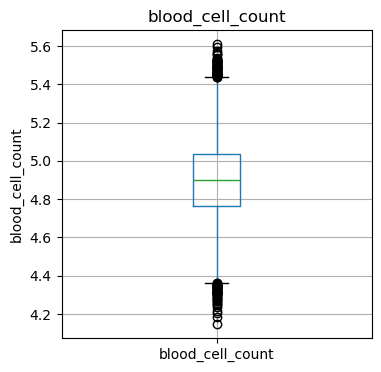

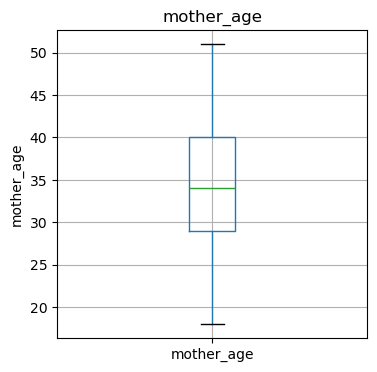

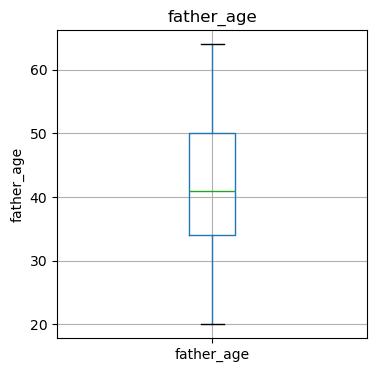

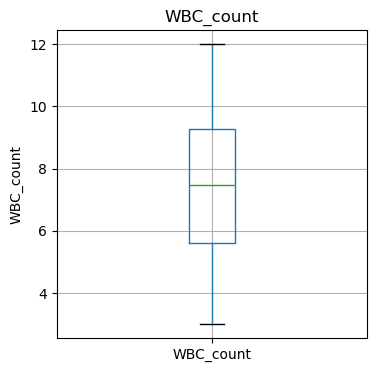

In [37]:
# Box plots
for feature in numerical_features:
  data = df.copy()

  if 0 in data[feature].unique():
    pass
  else:
    plt.figure(figsize=(4,4))
    data[feature] = data[feature]
    data.boxplot(column=feature)
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

In [38]:
# removing outliers
def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

# Apply on numerical features
num_cols = numerical_features
df_clean = remove_outliers_iqr(df, num_cols)

In [39]:
len(categorical_features)

28

In [40]:
categorical_features

['defective_mother',
 'defective_father',
 'maternal_gene',
 'paternal_gene',
 'Status',
 'respiratory_rate',
 'heart_rate',
 'follow_up',
 'Gender',
 'birth_asphyxia',
 'birth_defect_autopsy',
 'birth_place',
 'folic_acid_periconceptional',
 'maternal_illness',
 'radiation_exposure',
 'substance_abuse',
 'assisted_conception',
 'previous_pregnancy_anomalies',
 'num_previous_abortion',
 'birth_defects',
 'blood_test_result',
 'Symptom 1',
 'Symptom 2',
 'Symptom 3',
 'Symptom 4',
 'Symptom 5',
 'genetic_disorder',
 'disorder_subclass']

In [41]:
# label encoding
def label_encode_cat_features(data, cat_features):
    label_encoder = LabelEncoder()
    data_encoded = data.copy()
    
    for col in cat_features:
        data_encoded[col] = label_encoder.fit_transform(data[col])
    
    data = data_encoded
    return data

df = label_encode_cat_features(df, categorical_features)

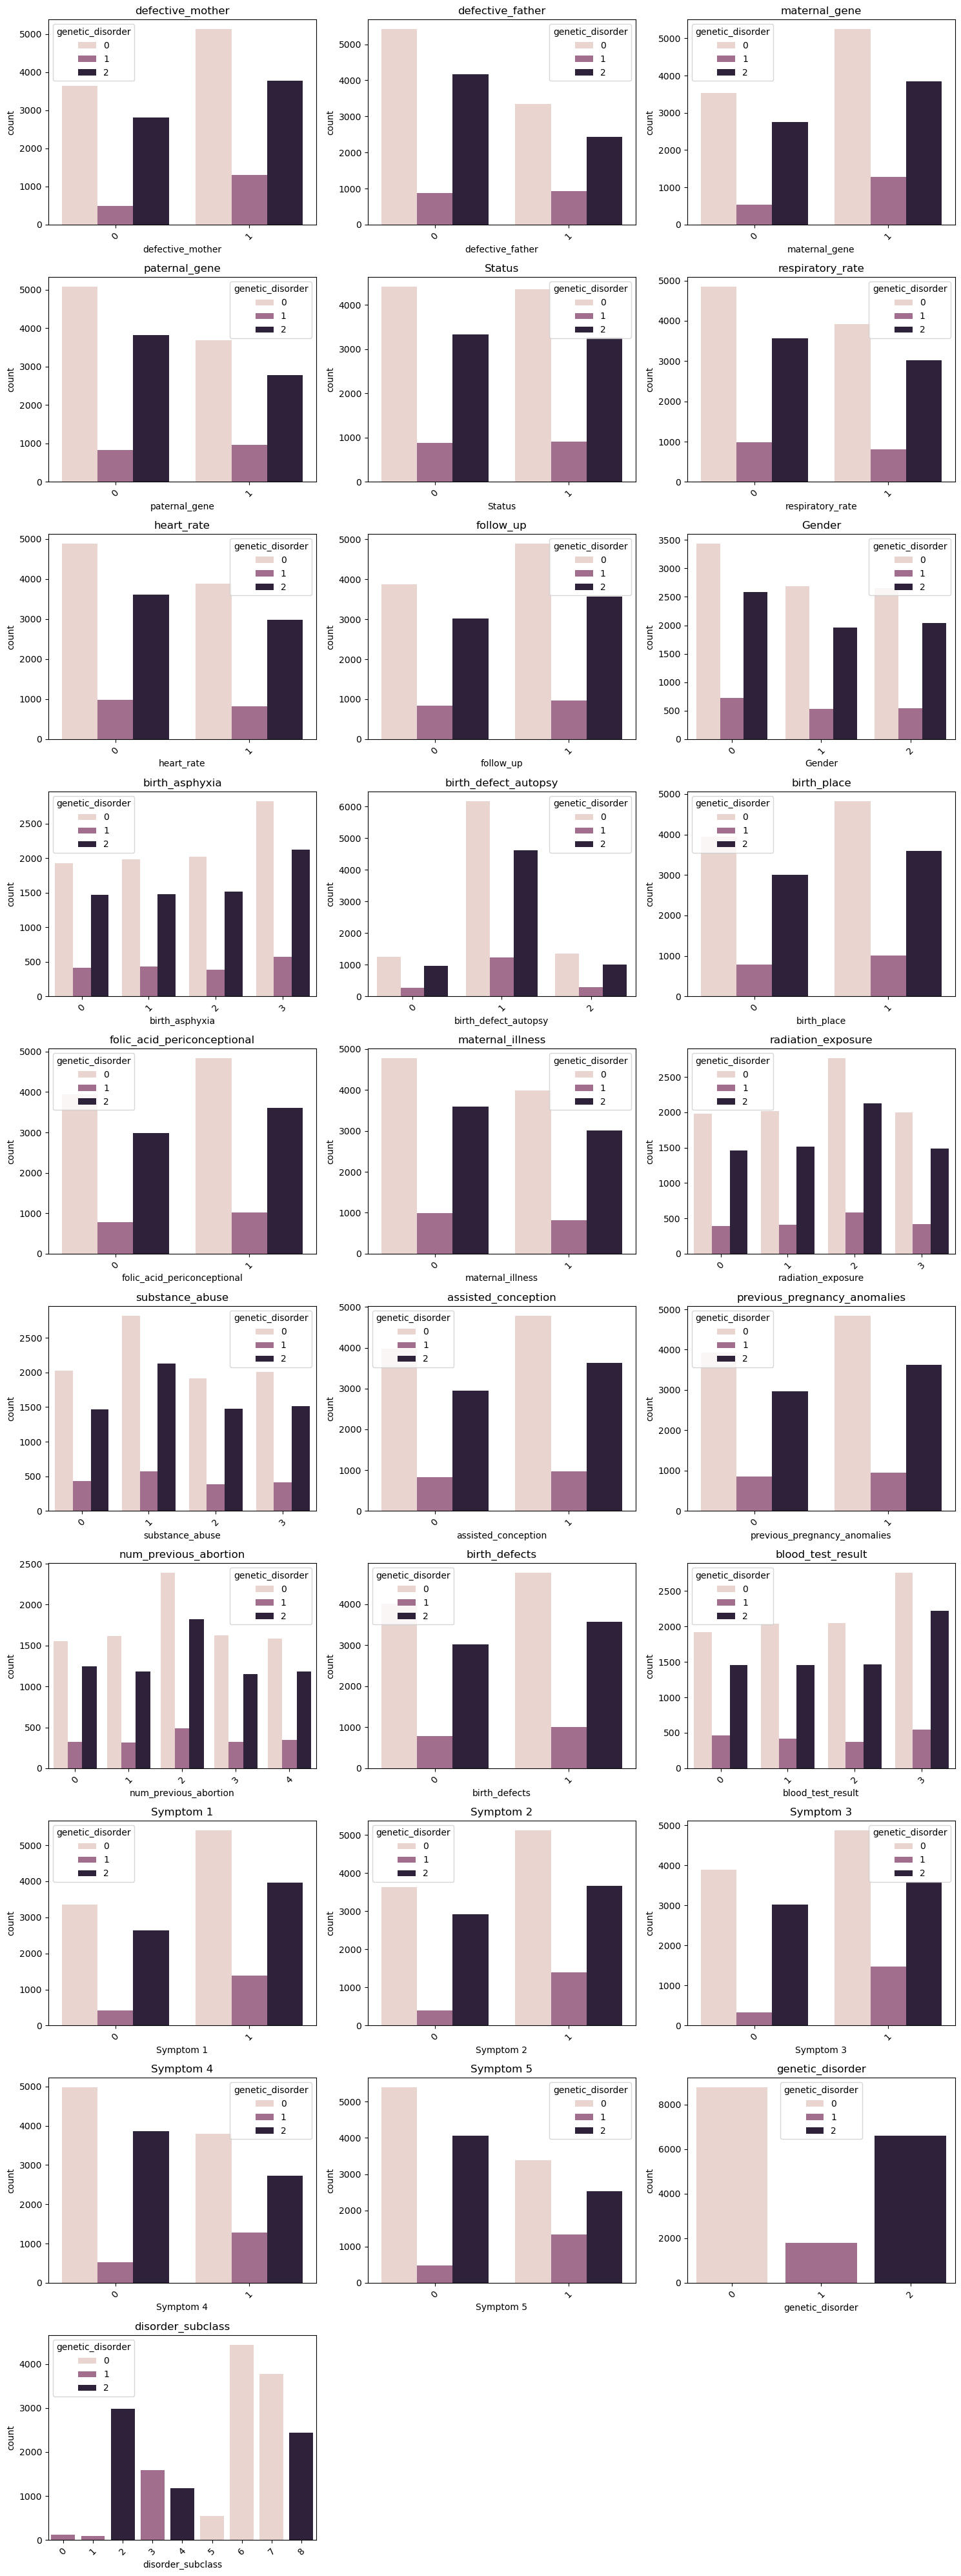

In [42]:
n_cols = 3
n_features = len(categorical_features)
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.countplot(data=df, x=feature, hue='genetic_disorder', ax=axes[i])
    axes[i].set_title(f"{feature}", fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

# Remove unused subplots
for j in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

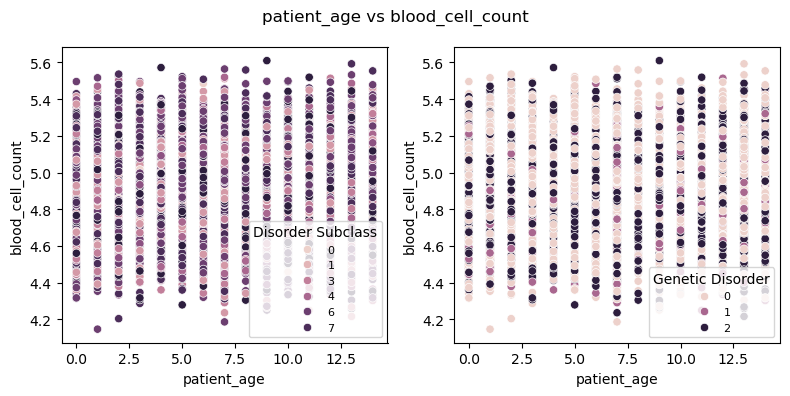

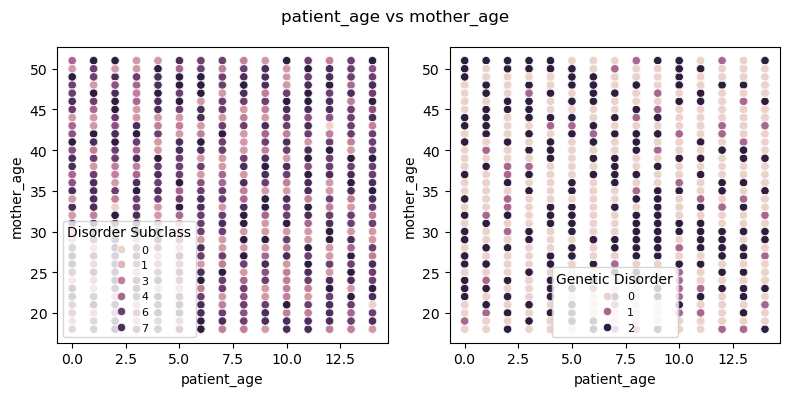

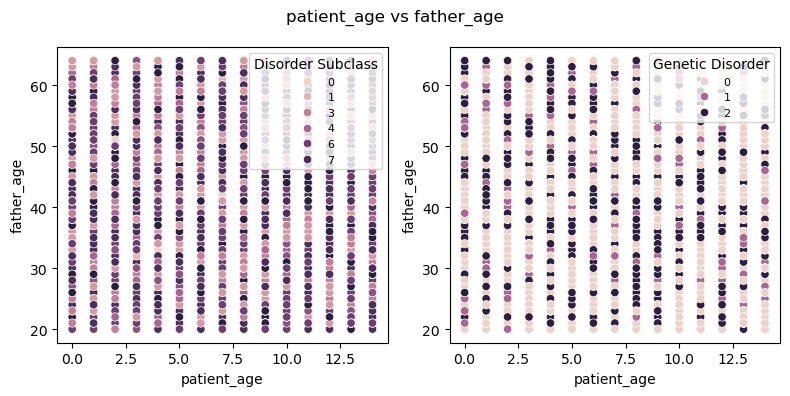

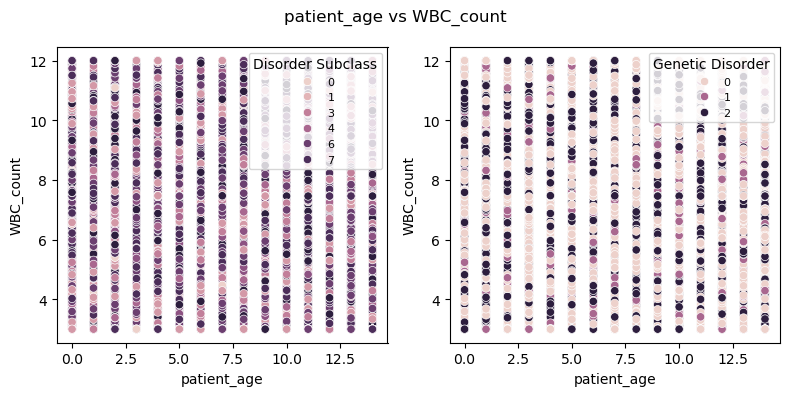

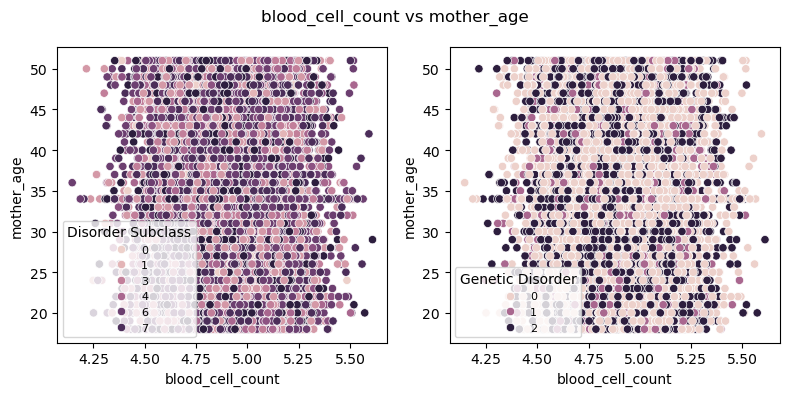

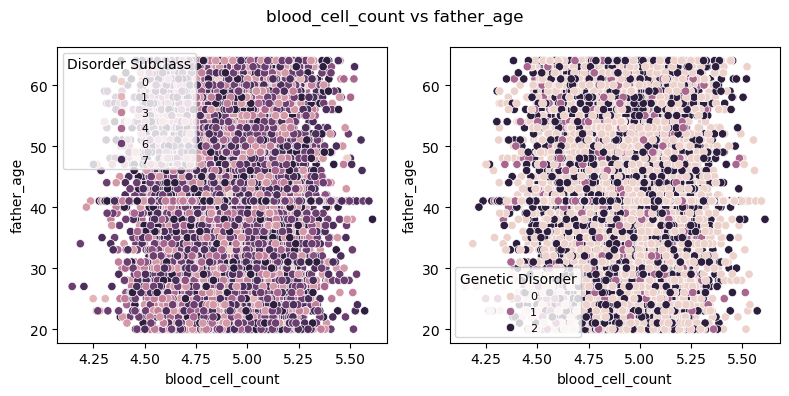

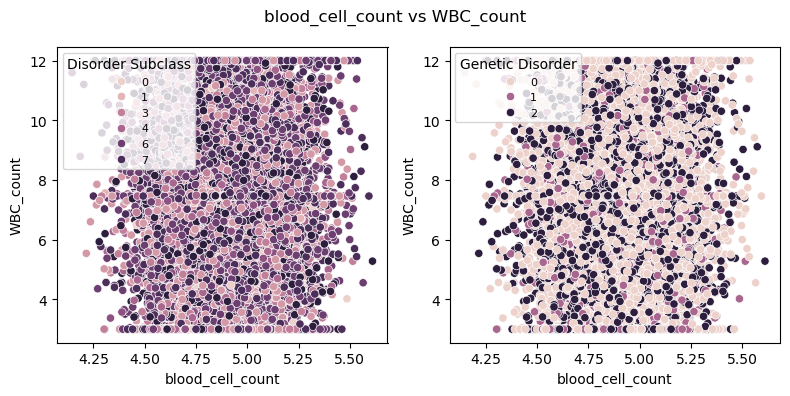

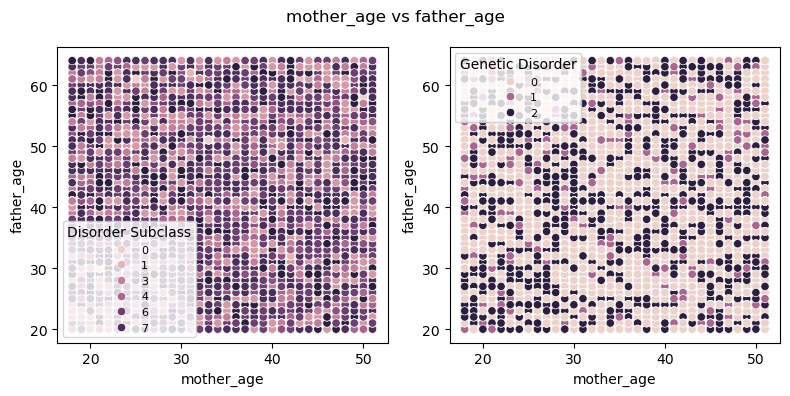

KeyboardInterrupt: 

In [43]:
# scatter plot
def check_pair(pair, pair_dict):
    f1, f2 = pair
    # If f1 already has f2 recorded or vice versa → duplicate
    if f1 in pair_dict and f2 in pair_dict[f1]:
        return False
    if f2 in pair_dict and f1 in pair_dict[f2]:
        return False
    return True

def append_pair(pair, pair_dict):
    f1, f2 = pair
    pair_dict.setdefault(f1, []).append(f2)
    pair_dict.setdefault(f2, []).append(f1)

pair_dict = dict()

for f1 in numerical_features:
    for f2 in numerical_features:
        if f1 == f2:
            continue
        else:
            pair = (f1, f2)
            if check_pair(pair, pair_dict):
                append_pair(pair, pair_dict)
                fig, axes = plt.subplots(1, 2, figsize=(8, 4))  
                
                # Left subplot: disorder_subclass
                sns.scatterplot(data=df, x=f1,y=f2, hue='disorder_subclass', ax=axes[0])
                axes[0].legend(title="Disorder Subclass", fontsize=8)
                
                # Right subplot: genetic_disorder
                sns.scatterplot(data=df, x=f1,y=f2, hue='genetic_disorder', ax=axes[1])
                axes[1].legend(title="Genetic Disorder", fontsize=8)
                plt.suptitle(f'{f1} vs {f2}')
                plt.tight_layout()
                plt.show()


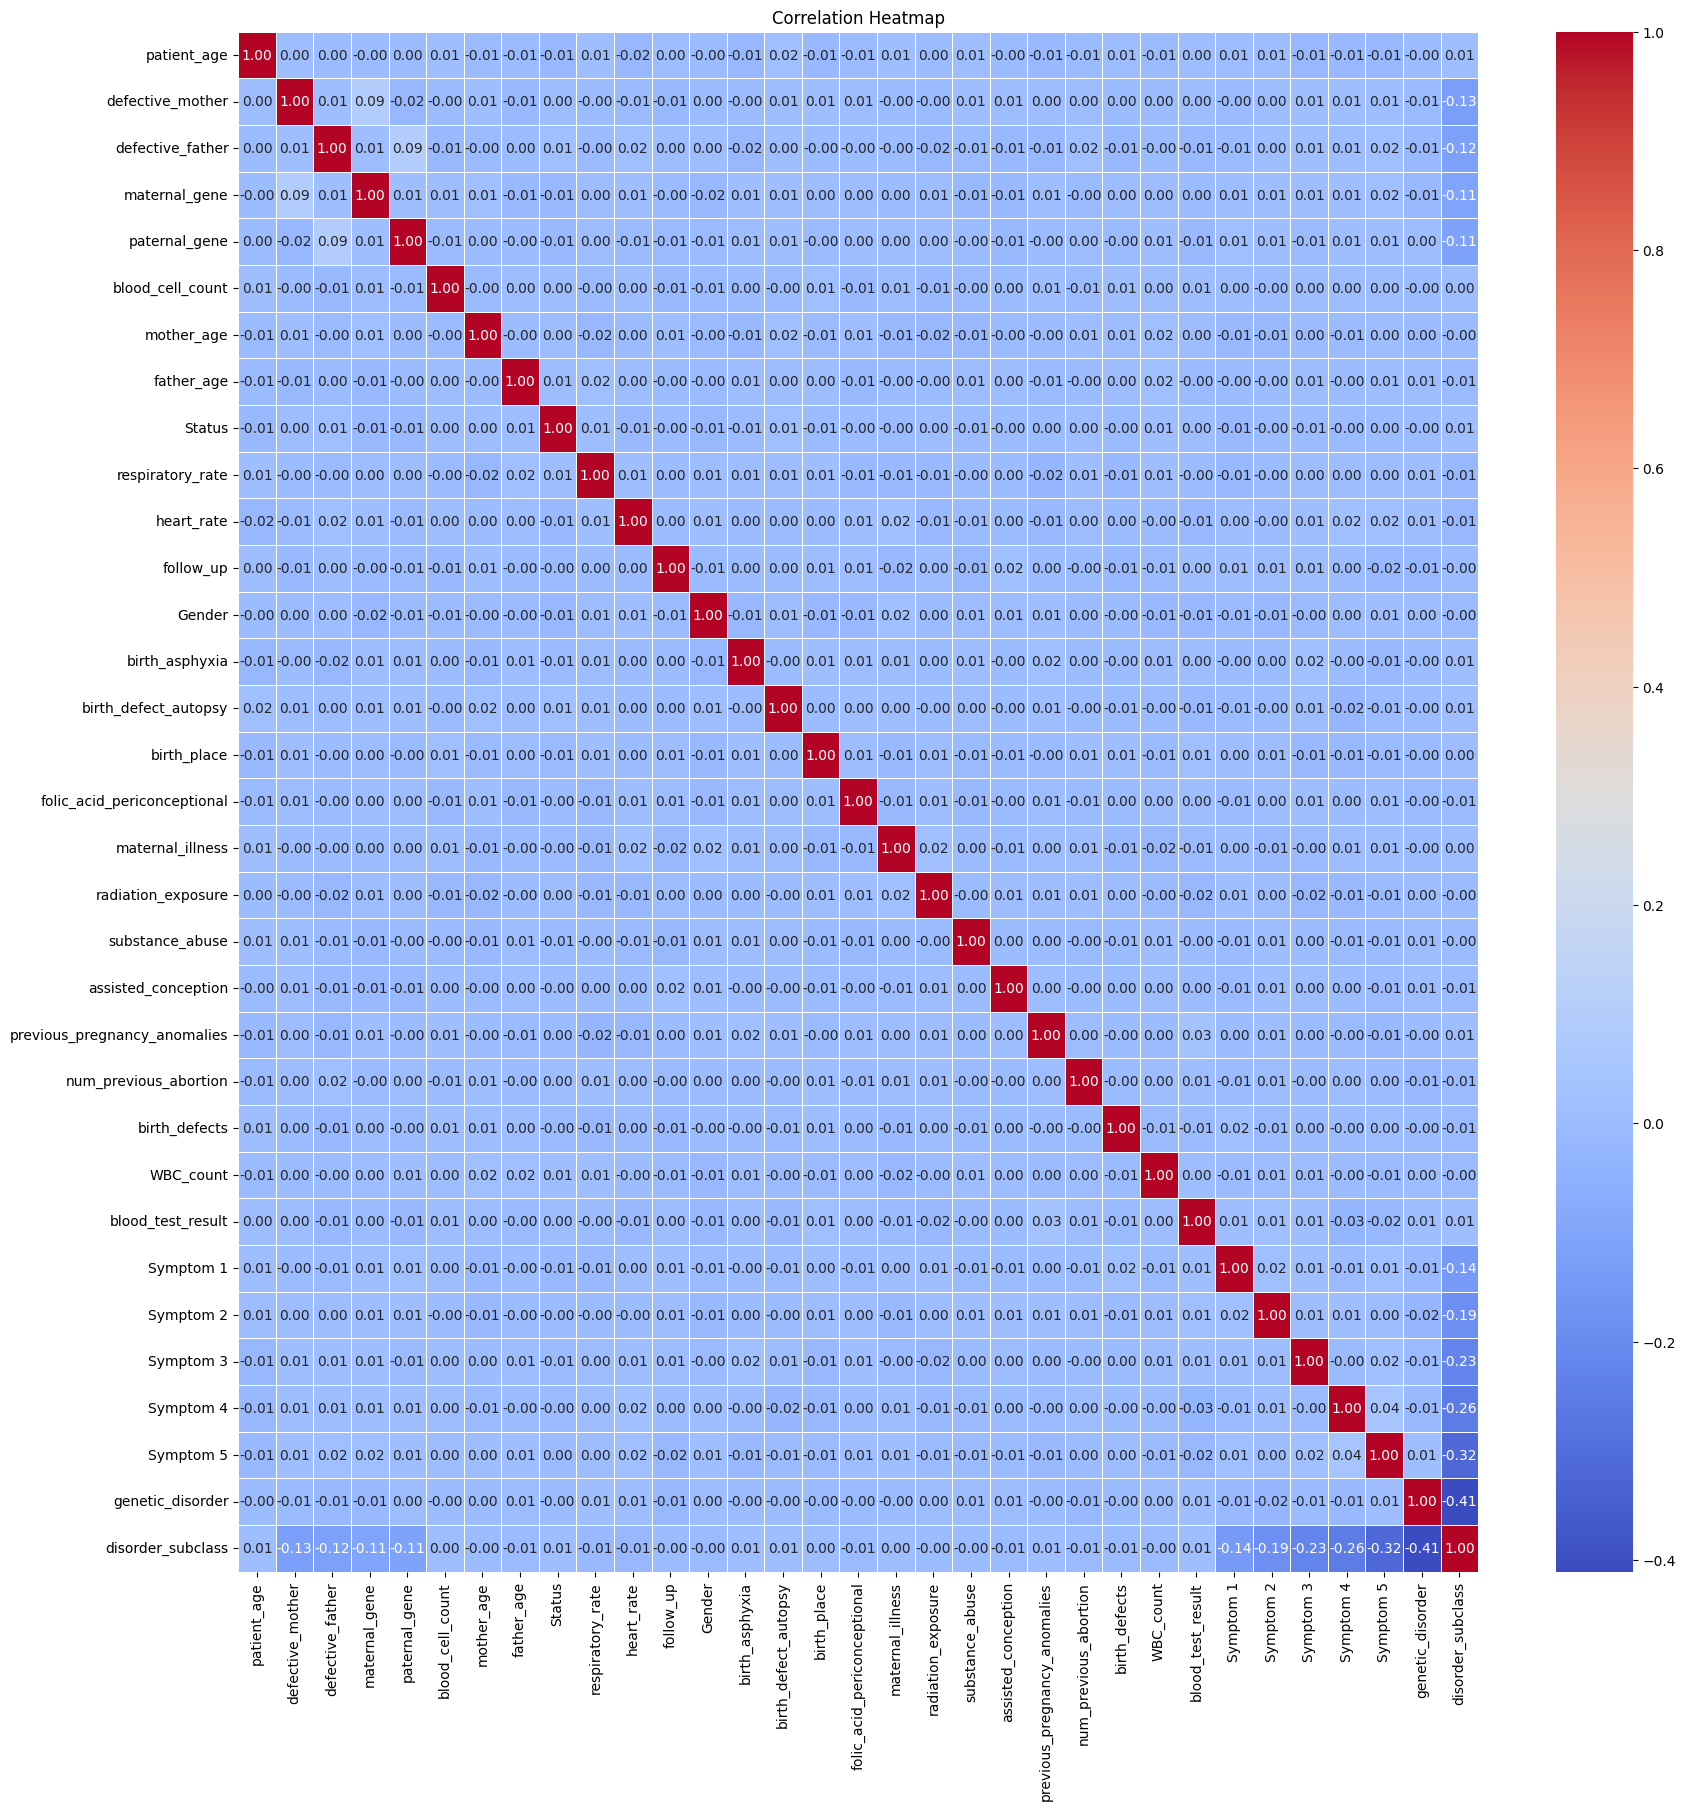

In [197]:
corr_matrix = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

There seems to be any significant correlation between the features.

## Model

In [44]:
X = df.drop(['genetic_disorder', 'disorder_subclass'], axis=1)
y = df[['genetic_disorder', 'disorder_subclass']] # to check later
X.head()

patient_age  defective_mother  defective_father  maternal_gene  \
0          2.0                 1                 0              1   
2          6.0                 1                 0              0   
3         12.0                 1                 0              1   
4         11.0                 1                 0              1   
5         14.0                 1                 0              1   

   paternal_gene  blood_cell_count  mother_age  father_age  Status  \
0              0          4.760603        34.0        41.0       0   
2              0          4.893297        41.0        22.0       0   
3              0          4.705280        21.0        41.0       1   
4              1          4.720703        32.0        41.0       0   
5              0          5.103188        34.0        41.0       1   

   respiratory_rate  heart_rate  follow_up  Gender  birth_asphyxia  \
0                 0           0          0       0               3   
2                 0           1          1       0               1   
3                 1           0          0       2               2   
4                 1           1          1       2               2   
5                 0           0          1       1               2   

   birth_defect_autopsy  birth_place  folic_acid_periconceptional  \
0                     1            1                            0   
2                     1            1                            1   
3                     0            1                            0   
4                     1            1                            0   
5                     1            1                            0   

   maternal_illness  radiation_exposure  substance_abuse  assisted_conception  \
0                 0                   1                1                    0   
2                 0                   3                1                    1   
3                 1                   0                2                    1   
4                 1                   0                2                    1   
5                 0                   1                1                    1   

   previous_pregnancy_anomalies  num_previous_abortion  birth_defects  \
0                             1                      2              1   
2                             1                      4              1   
3                             1                      1              1   
4                             0                      4              0   
5                             0                      0              0   

   WBC_count  blood_test_result  Symptom 1  Symptom 2  Symptom 3  Symptom 4  \
0   9.857562                  3          1          1          1          1   
2   7.461071                  2          0          1          1          1   
3   7.919321                  1          0          0          1          0   
4   4.098210                  3          0          0          0          0   
5  10.272230                  2          1          0          0          1   

   Symptom 5  
0          1  
2          1  
3          0  
4          0  
5          0

In [153]:
# finding optimal k using elbow method
sse = []
for i in range(1,12):
    kmeans = KMeans(n_clusters=i , max_iter=300)
    kmeans.fit(X) 
    sse.append(kmeans.inertia_)

fig = px.line(y=sse,template="seaborn",title='Eblow Method')
fig.update_layout(width=600, height=600,)

According to the above graph, at K = 3 we see a sharp deviation, hence it is the optimal K. 

In [38]:
seed = 42

In [39]:
def model_evaluate(model_names, model_list, X):
    result_log = dict()
    
    for name, model in zip(model_names, model_list):
        # Fit and predict
        labels = model.fit_predict(X)
        
        # Check number of clusters (excluding noise for DBSCAN, label = -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        if n_clusters > 1:  # only evaluate if ≥2 clusters
            db_index = davies_bouldin_score(X, labels)
            ss_score = silhouette_score(X, labels)
            result_log[name] = [db_index, ss_score]
        else:
            result_log[name] = ["Not Applicable", "Not Applicable"]
    
    return result_log

In [ ]:
# models
model_kmean = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300)
model_agg3 = AgglomerativeClustering(n_clusters=3)

model_list = [model_kmean, model_agg3]
model_name = ["kmean", "agg_3"]

result_log = model_evaluate(model_name, model_list, X)

In [164]:
result_log

{'kmean': [2.87269547753144, 0.07966813405345174],
 'agg_3': [3.3574354066652763, 0.04587974177392973]}

###  Interpreting these metrics
#### Davies–Bouldin Index (DBI)
- Lower is better.
- It measures cluster similarity:
  - 0 = perfectly separated clusters
  - Higher values = clusters overlap more

- KMeans: `2.87` (better)
- Agglomerative (3 clusters): `3.35` (worse separation)



#### Silhouette Score
- Range: [-1, 1]
  - Close to 1: well-separated, compact clusters
  - Around 0: overlapping clusters
  - Negative: points assigned to wrong clusters

- KMeans: `0.079` → clusters are very weakly separated
- Agglomerative: `0.046` → even weaker

In [45]:
# Standard scaling
X_std = StandardScaler().fit_transform(X)

# Robust scaling (good if many outliers)
X_rob = RobustScaler().fit_transform(X)

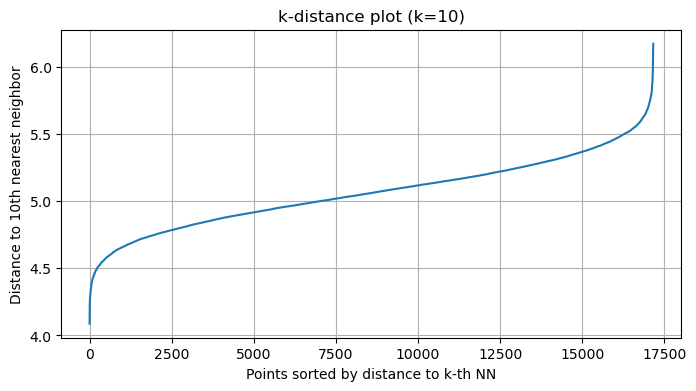

In [46]:
def plot_k_distance(X_arr, k=5):
    nbrs = NearestNeighbors(n_neighbors=k).fit(X_arr)
    distances, indices = nbrs.kneighbors(X_arr)
    # distance to k-th neighbor (k-1 index because neighbors include self)
    k_dist = distances[:, -1]
    k_dist_sorted = np.sort(k_dist)
    plt.figure(figsize=(8,4))
    plt.plot(k_dist_sorted)
    plt.xlabel("Points sorted by distance to k-th NN")
    plt.ylabel(f"Distance to {k}th nearest neighbor")
    plt.title(f"k-distance plot (k={k})")
    plt.grid(True)
    plt.show()

plot_k_distance(X_std, k=10)   # if you plan min_samples=10


In [47]:
def dbscan_eps_scan(X_arr, eps_values, min_samples=5):
    results = []
    n = X_arr.shape[0]
    for eps in eps_values:
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_arr)
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)
        results.append((eps, n_clusters, n_noise, n_noise / n))
    return results

# # Example eps grid (adjust to scale of your k-distance plot)
# eps_grid = np.linspace(0.01, 1.0, 20)   # tweak range accordingly
# res = dbscan_eps_scan(X_std, eps_grid, min_samples=10)

# # Print nicely
# for eps, n_clusters, n_noise, frac_noise in res:
#     print(f"eps={eps:.3f}  clusters={n_clusters:2d}  noise={n_noise:5d}  frac_noise={frac_noise:.3f}")


In [183]:
eps_grid = np.linspace(0.01, 100.0, 25)
min_samples_grid = [3, 5, 7, 10, 15]

best = []
for min_samples in min_samples_grid:
    print(min_samples)
    res = dbscan_eps_scan(X_std, eps_grid, min_samples=min_samples)
    # collect rows where number of clusters >= 2
    for eps, n_clusters, n_noise, frac_noise in res:
        best.append((min_samples, eps, n_clusters, frac_noise))
        print(f"min_samples={min_samples}, eps={eps:.3f}, clusters={n_clusters:2d}, frac_noise={frac_noise:.3f}")
    print()

3
eps=0.010  clusters= 0  noise=17160  frac_noise=1.000
eps=4.176  clusters=465  noise=14273  frac_noise=0.832
min_samples=3, eps=0.010, clusters= 0, frac_noise=1.000
min_samples=3, eps=4.176, clusters=465, frac_noise=0.832

5
eps=0.010  clusters= 0  noise=17160  frac_noise=1.000
eps=4.176  clusters=87  noise=16459  frac_noise=0.959
min_samples=5, eps=0.010, clusters= 0, frac_noise=1.000
min_samples=5, eps=4.176, clusters=87, frac_noise=0.959

7
eps=0.010  clusters= 0  noise=17160  frac_noise=1.000
eps=4.176  clusters=15  noise=17006  frac_noise=0.991
min_samples=7, eps=0.010, clusters= 0, frac_noise=1.000
min_samples=7, eps=4.176, clusters=15, frac_noise=0.991

10
eps=0.010  clusters= 0  noise=17160  frac_noise=1.000
eps=4.176  clusters= 3  noise=17127  frac_noise=0.998
eps=8.342  clusters= 1  noise=    0  frac_noise=0.000
eps=12.509  clusters= 1  noise=    0  frac_noise=0.000
eps=16.675  clusters= 1  noise=    0  frac_noise=0.000
eps=20.841  clusters= 1  noise=    0  frac_noise=0.000

In [186]:
# DBSCAN
db = DBSCAN(eps=4.176, min_samples=10)  
labels = db.fit_predict(X_std)


# Number of clusters (excluding noise)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("Number of clusters (excluding noise):", n_clusters_)

# Only evaluate if at least 2 clusters
if n_clusters_ > 1:
    db_index = davies_bouldin_score(X, labels)
    ss_score = silhouette_score(X, labels)
    print(f"Davies-Bouldin Score: {db_index:.4f}")
    print(f"Silhouette Score: {ss_score:.4f}")
else:
    print("Not enough clusters for evaluation.")

Number of clusters (excluding noise): 3
Davies-Bouldin Score: 2.9490
Silhouette Score: -0.1276


In [187]:
# Fit GMM with 3 clusters (change n_components if needed)
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
labels_gmm = gmm.fit_predict(X)

db_index_gmm = davies_bouldin_score(X, labels_gmm)
ss_score_gmm = silhouette_score(X, labels_gmm)

print("Gaussian Mixture Model:")
print(f"  Davies-Bouldin Score: {db_index_gmm:.4f}")
print(f"  Silhouette Score: {ss_score_gmm:.4f}")


Gaussian Mixture Model:
  Davies-Bouldin Score: 2.9536
  Silhouette Score: 0.0717


In [190]:
# Spectral Clustering
sc = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
labels_sc = sc.fit_predict(X)

db_index_sc = davies_bouldin_score(X, labels_sc)
ss_score_sc = silhouette_score(X, labels_sc)

print("Spectral Clustering:")
print(f"  Davies-Bouldin Score: {db_index_sc:.4f}")
print(f"  Silhouette Score: {ss_score_sc:.4f}")

Spectral Clustering:
  Davies-Bouldin Score: 2.9938
  Silhouette Score: 0.0682


| Model   | Davies-Bouldin Score | Silhouette Score |
|---------|----------------------|------------------|
| kmean   | 2.8726               | 0.0796           |
| agg_3   | 3.3574               | 0.0458           |
| DBscan  | 2.9490               | -0.1276          |
| GMM     | 2.9536               | 0.0717           |
| SC      | 2.9938               | 0.0682           |


## PCA

In [48]:
# Fit PCA without limiting components
pca = PCA()
X_pca = pca.fit_transform(X_std)

# Explained variance ratio
explained_var = np.cumsum(pca.explained_variance_ratio_)

# plt.figure(figsize=(8,5))
# plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Explained Variance by PCA Components')
# plt.grid(True)
# plt.show()

In [72]:
y.columns

Index(['genetic_disorder', 'disorder_subclass'], dtype='object')

In [74]:
fig = px.scatter(x=X_pca[:, 0], y=X_pca[:, 1], color=y['disorder_subclass'])
fig.update_layout(
    title="PCA visualization",
    xaxis_title="First Principal Component",
    yaxis_title="Second Principal Component",
)
fig.show()

In [75]:
fig = px.scatter(x=X_pca[:, 0], y=X_pca[:, 1], color=y['genetic_disorder'])
fig.update_layout(
    title="PCA visualization",
    xaxis_title="First Principal Component",
    yaxis_title="Second Principal Component",
)
fig.show()

In [49]:
# Example: keep enough PCs for 95% variance
pca_25 = PCA(n_components=0.25)   # keeps min PCs that explain 95% variance
X_reduced = pca_25.fit_transform(X_std)

pca_45 = PCA(n_components=0.45)
X_reduced_45 = pca_45.fit_transform(X_std)

print("Original shape:", X.shape)
print("Reduced shape:", X_reduced.shape)
print("Reduced shape:", X_reduced_45.shape)

Original shape: (17160, 31)
Reduced shape: (17160, 8)
Reduced shape: (17160, 14)


In [85]:
X_reduced.shape

(17160, 8)

In [86]:
fig = px.scatter(x=X_reduced_45[:, 1], y=X_reduced_45[:, 2], color=y['genetic_disorder'])
fig.update_layout(
    title="PCA visualization",
    xaxis_title="First Principal Component",
    yaxis_title="Second Principal Component",
)
fig.show()

In [ ]:
# finding optimal k using elbow method
sse = []
for i in range(1,30):
    kmeans = KMeans(n_clusters=i , max_iter=300)
    kmeans.fit(X_pca) 
    sse.append(kmeans.inertia_)

fig = px.line(y=sse,template="seaborn",title='Eblow Method')
fig.update_layout(width=600, height=600,)

We can check values at k=5,9,11,12,13,14,17, 18, 19 and 20.

In [ ]:
# finding optimal k using elbow method
sse = []
for i in range(1,30):
    kmeans = KMeans(n_clusters=i , max_iter=300)
    kmeans.fit(X_reduced) 
    sse.append(kmeans.inertia_)

fig = px.line(y=sse,template="seaborn",title='Eblow Method')
fig.update_layout(width=600, height=600,)

We can observe deviations at 12 and 13

In [ ]:
# finding optimal k using elbow method
sse = []
for i in range(1,30):
    kmeans = KMeans(n_clusters=i , max_iter=300)
    kmeans.fit(X_reduced_45) 
    sse.append(kmeans.inertia_)

fig = px.line(y=sse,template="seaborn",title='Eblow Method')
fig.update_layout(width=1000, height=600,)

We can observe deviation at 4 and 12

In [ ]:
eps_grid = np.linspace(0.01, 100.0, 25)
min_samples_grid = [3, 5, 7, 10, 15]

best = []
for min_samples in min_samples_grid:
    print(min_samples)
    res = dbscan_eps_scan(X_reduced, eps_grid, min_samples=min_samples)
    # collect rows where number of clusters >= 2
    for eps, n_clusters, n_noise, frac_noise in res:
        best.append((min_samples, eps, n_clusters, frac_noise))
        print(f"min_samples={min_samples}, eps={eps:.3f}, clusters={n_clusters:2d}, frac_noise={frac_noise:.3f}")
    print()

In [145]:
X_pca

array([[ 0.41169296,  2.5841551 , -0.54878129, ..., -0.23539077,
        -0.53110459, -0.2653756 ],
       [-0.08806211,  1.35822344, -0.77293271, ...,  0.18103148,
        -1.40458773,  0.89513252],
       [-1.20820003,  0.47065498, -1.45920279, ...,  1.46648028,
         1.30408092,  0.12893093],
       ...,
       [-0.53641233, -1.18240568, -0.49795854, ..., -0.98793124,
        -0.3013415 ,  1.24980904],
       [ 0.32452852,  0.67891034,  1.06870971, ..., -0.07173698,
        -1.40645035,  1.88234453],
       [-0.25111096, -0.8520826 ,  0.0133883 , ...,  0.82785834,
         0.53726695, -2.41355294]], shape=(17160, 31))

In [ ]:
def model_evaluateV2(model_names, model_list):
    result_log = dict()
    
    for name, model in zip(model_names, model_list):
        # Fit and predict
        m1 = clone(model)
        m2 = clone(model)
        m3 = clone(model)

        m1_name = name + "_1"
        m2_name = name + "_2"
        m3_name = name + '_3'

        labels_1 = m1.fit_predict(X_pca)
        labels_2 = m2.fit_predict(X_reduced)
        labels_3 = m3.fit_predict(X_reduced_45)
        
        n_clusters_1 = len(set(labels_1)) - (1 if -1 in labels_1 else 0)
        n_clusters_2 = len(set(labels_2)) - (1 if -1 in labels_2 else 0)
        n_clusters_3 = len(set(labels_3)) - (1 if -1 in labels_3 else 0)
        
        if n_clusters_1 > 1:  
            db_index_1 = davies_bouldin_score(X_pca, labels_1)
            ss_score_1 = silhouette_score(X_pca, labels_1)
            result_log[m1_name] = [db_index_1, ss_score_1]
        else:
            result_log[m1_name] = ["Not Applicable", "Not Applicable"]
        
        if n_clusters_2 > 1:  # only evaluate if ≥2 clusters
            db_index_2 = davies_bouldin_score(X_reduced, labels_2)
            ss_score_2 = silhouette_score(X_reduced, labels_2)
            result_log[m2_name] = [db_index_2, ss_score_2]
        else:
            result_log[m2_name] = ["Not Applicable", "Not Applicable"]
        
        if n_clusters_3 > 1:  # only evaluate if ≥2 clusters
            db_index_3 = davies_bouldin_score(X_reduced_45, labels_3)
            ss_score_3 = silhouette_score(X_reduced_45, labels_3)
            result_log[m3_name] = [db_index_3, ss_score_3]
        else:
            result_log[m3_name] = ["Not Applicable", "Not Applicable"]
    
    return result_log

Model Davies-Bouldin Score Silhouette Score


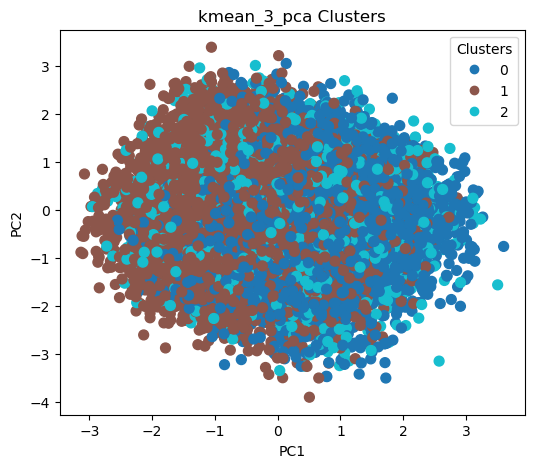

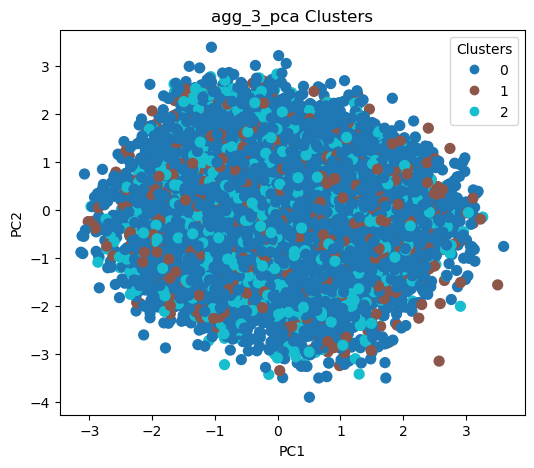

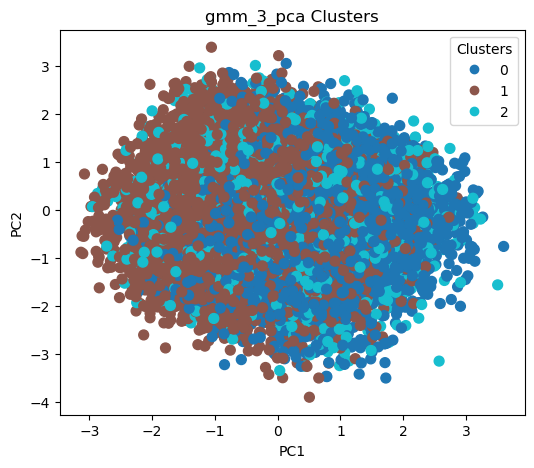

kmean_3_pca	4.9427	0.0330
kmean_3_reduced	2.6840	0.0836
kmean_3_reduced45	3.7356	0.0502
agg_3_pca	7.2299	0.0123
agg_3_reduced	3.9381	0.0320
agg_3_reduced45	6.0303	0.0141
gmm_3_pca	4.9427	0.0330
gmm_3_reduced	2.8720	0.0749
gmm_3_reduced45	3.8149	0.0484
--------------------------


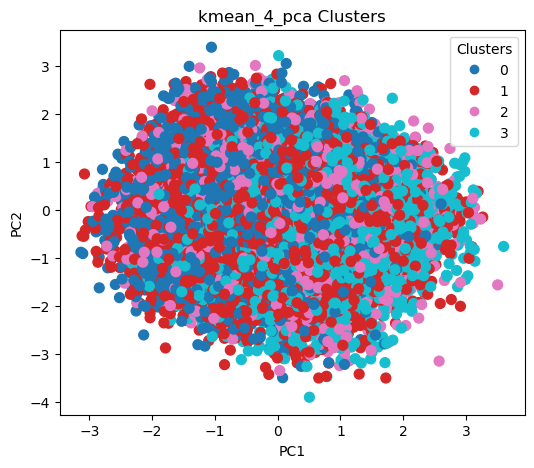

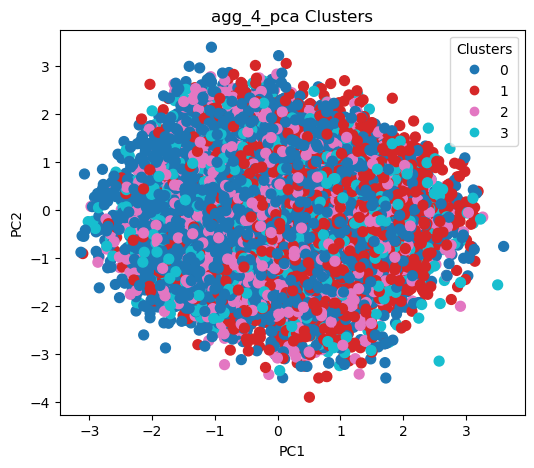

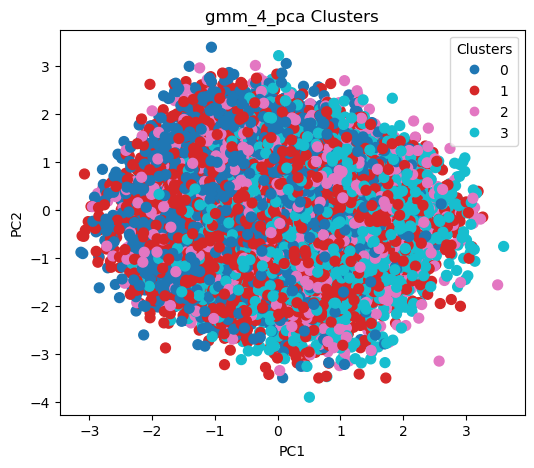

kmean_4_pca	4.8029	0.0299
kmean_4_reduced	2.5029	0.0778
kmean_4_reduced45	3.4647	0.0477
agg_4_pca	9.5168	0.0032
agg_4_reduced	3.5463	0.0225
agg_4_reduced45	5.4552	0.0077
gmm_4_pca	4.8029	0.0299
gmm_4_reduced	2.5725	0.0752
gmm_4_reduced45	3.6148	0.0451
--------------------------


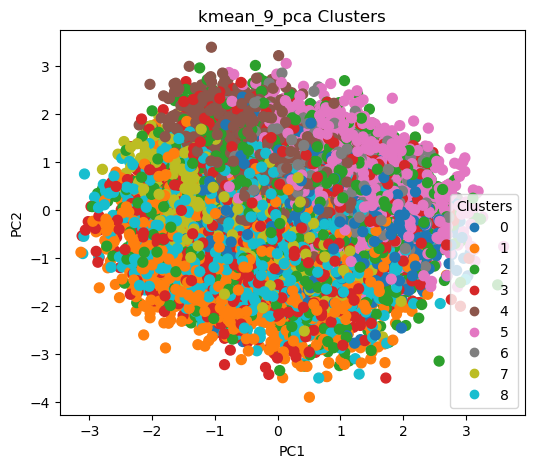

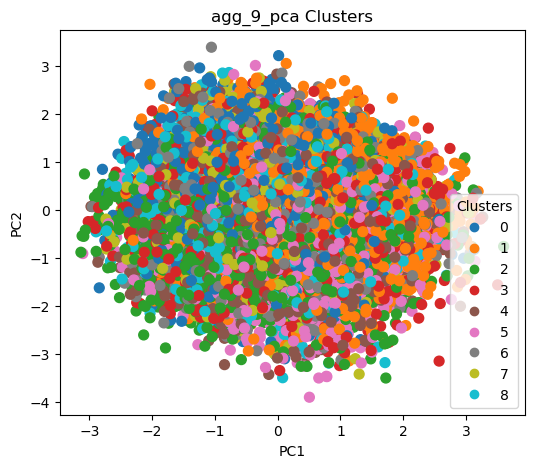

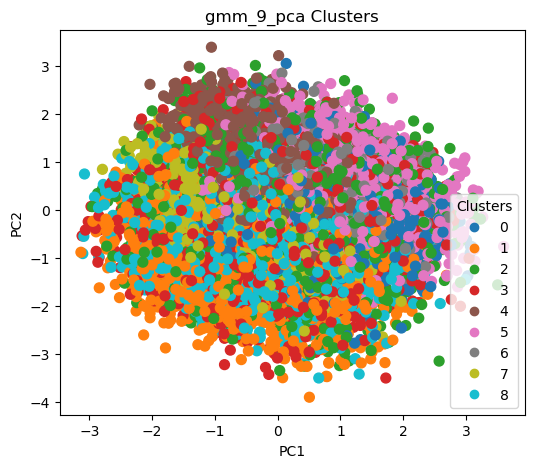

kmean_9_pca	4.8244	0.0174
kmean_9_reduced	1.9465	0.0824
kmean_9_reduced45	2.8036	0.0440
agg_9_pca	7.8083	-0.0051
agg_9_reduced	2.7689	0.0089
agg_9_reduced45	4.5055	-0.0042
gmm_9_pca	4.7478	0.0175
gmm_9_reduced	2.1499	0.0637
gmm_9_reduced45	3.6976	0.0090
--------------------------


In [146]:
def plot_clusters_col_2(arr, labels, title):
    plt.figure(figsize=(6,5))
    scatter = plt.scatter(arr[:,0], arr[:,1], c=labels, cmap="tab10", s=50)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.show()

def model_evaluateV2(model_names, model_list):
    result_log = dict()
    
    for name, model in zip(model_names, model_list):
        # Clone models
        m1 = clone(model)
        m2 = clone(model)
        m3 = clone(model)

        m1_name = name + "_pca"
        m2_name = name + "_reduced"
        m3_name = name + "_reduced45"

        labels_1 = m1.fit_predict(X_pca)         # 2D
        labels_2 = m2.fit_predict(X_reduced)     # 8D
        labels_3 = m3.fit_predict(X_reduced_45)  # 14D
        
        # --- Evaluation ---
        n_clusters_1 = len(set(labels_1)) - (1 if -1 in labels_1 else 0)
        n_clusters_2 = len(set(labels_2)) - (1 if -1 in labels_2 else 0)
        n_clusters_3 = len(set(labels_3)) - (1 if -1 in labels_3 else 0)
        
        if n_clusters_1 > 1:  
            db_index_1 = davies_bouldin_score(X_pca, labels_1)
            ss_score_1 = silhouette_score(X_pca, labels_1)
            result_log[m1_name] = [db_index_1, ss_score_1]
            
            # --- Plot only for X_pca (2D) ---
            plot_clusters_col_2(X_pca, labels_1, f"{m1_name} Clusters")
        else:
            result_log[m1_name] = ["Not Applicable", "Not Applicable"]
        
        if n_clusters_2 > 1:  
            db_index_2 = davies_bouldin_score(X_reduced, labels_2)
            ss_score_2 = silhouette_score(X_reduced, labels_2)
            result_log[m2_name] = [db_index_2, ss_score_2]
        else:
            result_log[m2_name] = ["Not Applicable", "Not Applicable"]
        
        if n_clusters_3 > 1:  
            db_index_3 = davies_bouldin_score(X_reduced_45, labels_3)
            ss_score_3 = silhouette_score(X_reduced_45, labels_3)
            result_log[m3_name] = [db_index_3, ss_score_3]
        else:
            result_log[m3_name] = ["Not Applicable", "Not Applicable"]
    
    return result_log


# ---- Run Evaluation ----
cluster_list = [3,4,9]
cluster_log = dict()

print("Model", "Davies-Bouldin Score","Silhouette Score")
for cluster_num in cluster_list:
    model_kmean_cluster_num = KMeans(n_clusters = cluster_num, init = 'k-means++', max_iter = 300, random_state=42)
    model_agg_cluster_num = AgglomerativeClustering(n_clusters=cluster_num)
    model_gmm_cluster_num = GaussianMixture(n_components=cluster_num, covariance_type='full', random_state=42)

    model_list = [model_kmean_cluster_num, model_agg_cluster_num, model_gmm_cluster_num]
    model_name = [f"kmean_{cluster_num}", f"agg_{cluster_num}", f"gmm_{cluster_num}"]

    result_log_cluster_num = model_evaluateV2(model_name, model_list)
    cluster_log[cluster_num] = result_log_cluster_num

    for key, value in result_log_cluster_num.items():
        print(key, f'{value[0]:.4f}', f'{value[1]:.4f}', sep="\t")
        
    print("--------------------------")


## t-SNE

In [78]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne_2 = tsne.fit_transform(X)
tsne.kl_divergence_

2.0475716590881348

In [87]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_std)
tsne.kl_divergence_

4.622601509094238

X_std is giving worst KL divergence

In [94]:
cluster_list = [2,3]
tsne_log = dict()
for cluster in cluster_list:
    tsne = TSNE(n_components=cluster, random_state=42)
    X_tsne = tsne.fit_transform(X_std)
    tsne_log[cluster] = [tsne,X_tsne]
    print(f"{cluster}: {tsne.kl_divergence_:.4f}")

2: 4.6226
3: 4.4107


In [95]:
cluster_list = [2,3]
tsne_log_2 = dict()
for cluster in cluster_list:
    tsne = TSNE(n_components=cluster, random_state=42)
    X_tsne = tsne.fit_transform(X)
    tsne_log_2[cluster] = [tsne, X_tsne]
    print(f"{cluster}: {tsne.kl_divergence_:.4f}")

2: 2.0476
3: 1.8346


In [93]:
cluster_list

[2, 3]

In [125]:
tsne_prim = tsne_log[2][-1]
fig = px.scatter(x=tsne_prim[:, 0], y=tsne_prim[:, 1], color=y['genetic_disorder'])
fig.update_layout(
    title="t-SNE visualization of Custom Classification dataset",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

In [126]:
tsne_prim = tsne_log[3][-1]
fig = px.scatter(x=tsne_prim[:, 0], y=tsne_prim[:, 1], color=y['disorder_subclass'])
fig.update_layout(
    title="t-SNE visualization of Custom Classification dataset",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

In [ ]:
tsne_prim = tsne_log_2[2][-1]
fig = px.scatter(x=tsne_prim[:, 0], y=tsne_prim[:, 1], color=y['genetic_disorder'])
fig.update_layout(
    title="t-SNE visualization of dataset",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

We are able to makeout 9 clusters in the above graph.

In [ ]:
tsne_prim = tsne_log_2[3][-1]
fig = px.scatter(x=tsne_prim[:, 0], y=tsne_prim[:, 1], color=y['disorder_subclass'])
fig.update_layout(
    title="t-SNE visualization of dataset",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

We are able to observe 9 clusters from the above graph.

Moving forward we will be using tsne_log_2 dictionary.

In [133]:
tsne_X_data = [val[-1] for _, val in tsne_log_2.items()]
tsne_X_data

[array([[-24.376324 ,  -5.489877 ],
        [-72.45021  ,  38.485397 ],
        [ 10.099122 , -66.48932  ],
        ...,
        [-37.31652  ,   5.0242763],
        [-77.33064  ,  14.735538 ],
        [-75.79459  ,  46.759453 ]], shape=(17160, 2), dtype=float32),
 array([[ -1.1926506 ,   4.0695634 , -12.444393  ],
        [-22.282919  ,   8.399694  ,   0.14505424],
        [ -1.9056189 , -20.64659   ,   5.1130223 ],
        ...,
        [ -8.777539  ,  -1.6560315 ,  -0.9758723 ],
        [-22.782574  ,   1.640517  ,  -8.247282  ],
        [-20.741348  ,  10.200112  ,   5.295375  ]],
       shape=(17160, 3), dtype=float32)]

In [134]:
tsne_X_data[1].shape, tsne_X_data[0].shape

((17160, 3), (17160, 2))

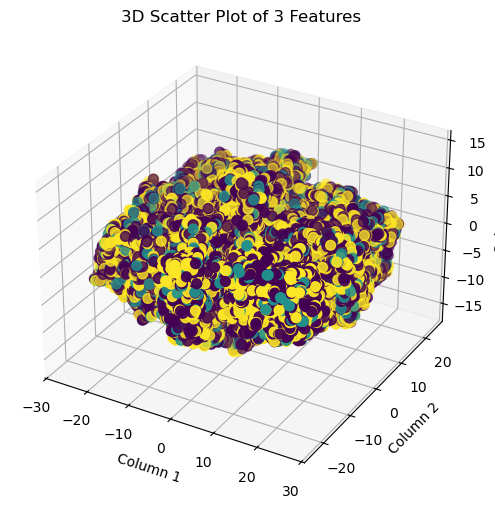

In [135]:
# Create 3D figure
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

df_tsne_3 = pd.DataFrame(tsne_X_data[1], columns=['ColA', 'ColB', 'ColC'])
# Scatter plot
ax.scatter(df_tsne_3['ColA'], df_tsne_3["ColB"], df_tsne_3["ColC"], c=y['genetic_disorder'], cmap="viridis", s=50)

# Labels
ax.set_xlabel("Column 1")
ax.set_ylabel("Column 2")
ax.set_zlabel("Column 3")
ax.set_title("3D Scatter Plot of 3 Features")

plt.show()


In [138]:
# finding optimal k using elbow method
sse = []
for i in range(1,30):
    kmeans = KMeans(n_clusters=i , max_iter=100)
    kmeans.fit(tsne_X_data[0]) 
    sse.append(kmeans.inertia_)

fig = px.line(y=sse,template="seaborn",title='Eblow Method')
fig.update_layout(width=1000, height=600,)

From the abve graphs, we can observe significant diviation at K = 3,9,10.  

In [139]:
# finding optimal k using elbow method
sse = []
for i in range(1,30):
    kmeans = KMeans(n_clusters=i , max_iter=100)
    kmeans.fit(tsne_X_data[1]) 
    sse.append(kmeans.inertia_)

fig = px.line(y=sse,template="seaborn",title='Eblow Method')
fig.update_layout(width=1000, height=600,)

From the abve graphs, we can observe significant diviation at K = 3,9. 

In [141]:
def plot_clusters_col_3(arr, labels, title):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection="3d")
    scatter = ax.scatter(
        arr[:,0], arr[:,1], arr[:,2],
        c=labels, cmap="tab10", s=50
    )
    ax.set_xlabel("col1")
    ax.set_ylabel("col2")
    ax.set_zlabel("col3")
    ax.set_title(title)
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.show()

def plot_clusters_col_2(arr, labels, title):
    plt.figure(figsize=(6,5))
    scatter = plt.scatter(arr[:,0], arr[:,1], c=labels, cmap="tab10", s=50)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.show()

Model Davies-Bouldin Score Silhouette Score


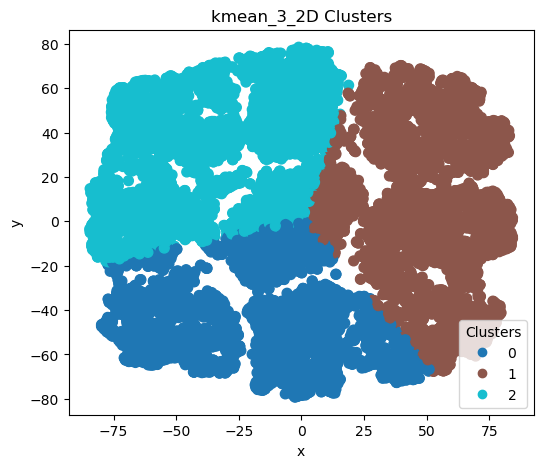

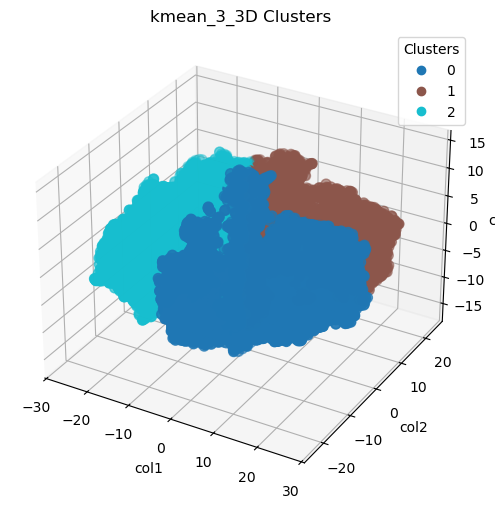

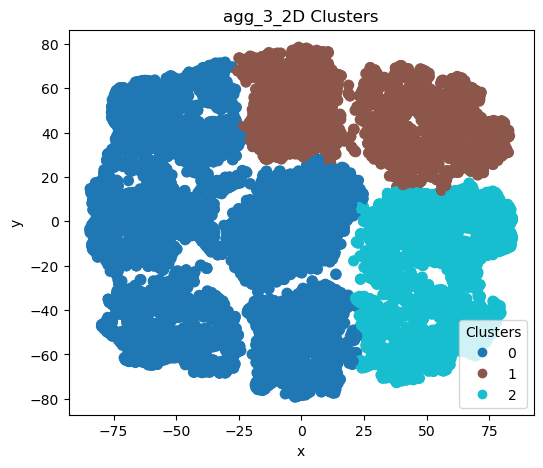

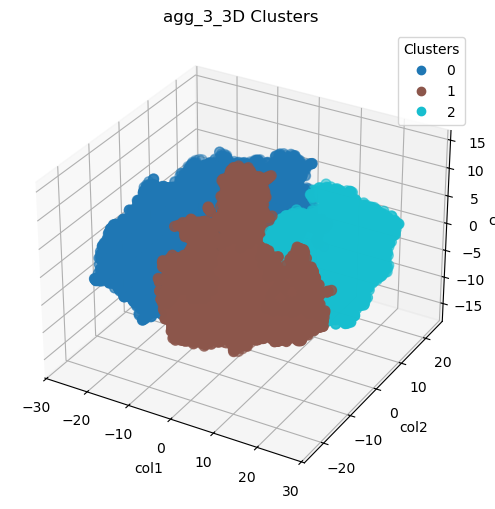

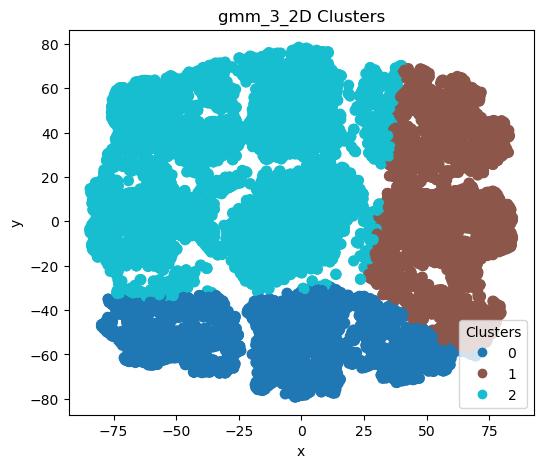

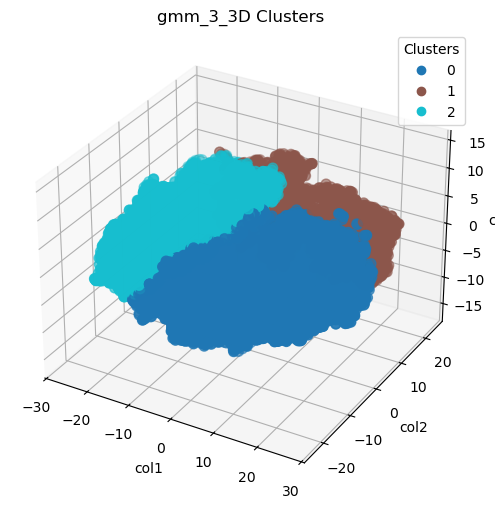

kmean_3_2D		0.8956957887965226		0.37360715866088867
kmean_3_3D		1.08013091449904		0.313681960105896
agg_3_2D		0.8939420149386906		0.3296516537666321
agg_3_3D		1.2341406969790125		0.27908992767333984
gmm_3_2D		0.9471863120602467		0.3407497704029083
gmm_3_3D		1.1553235585463664		0.26960301399230957
--------------------------


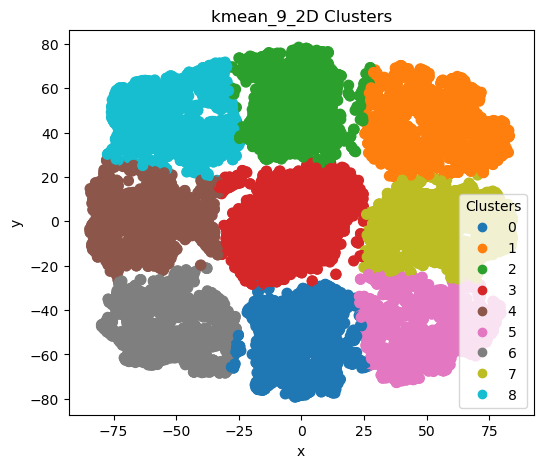

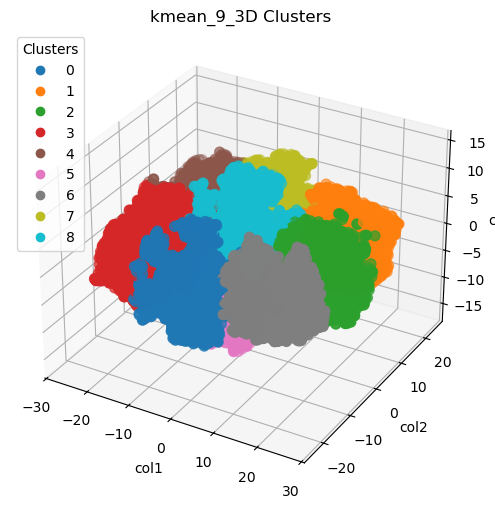

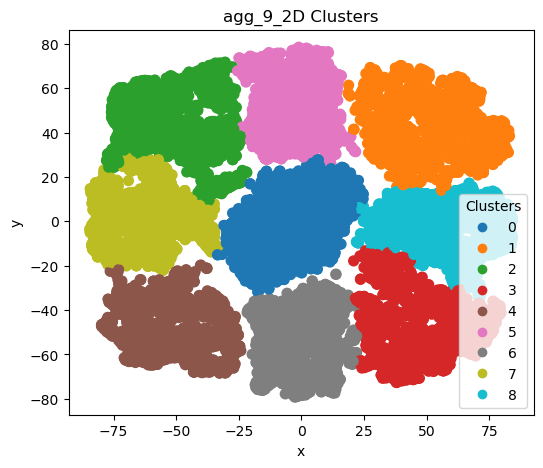

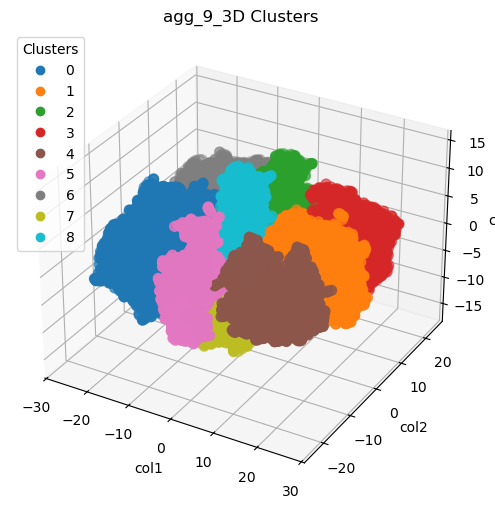

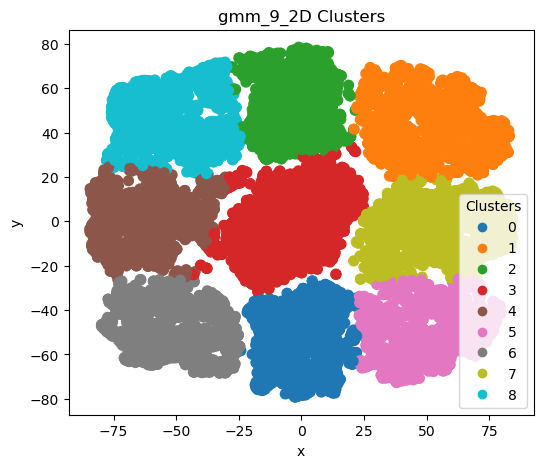

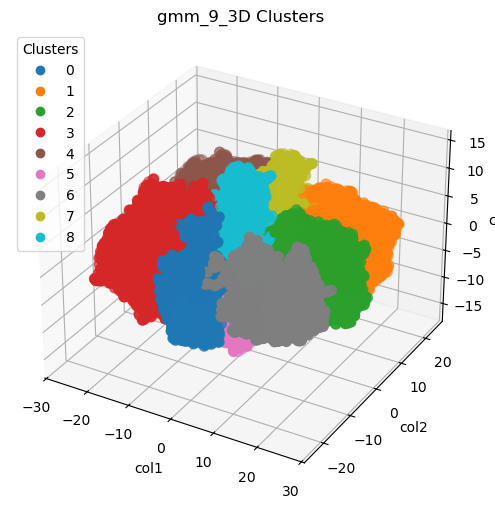

kmean_9_2D		0.7238909107271649		0.4331345558166504
kmean_9_3D		0.9539043444428204		0.3400546908378601
agg_9_2D		0.7508109885962821		0.42197084426879883
agg_9_3D		0.9765048710139028		0.31550133228302
gmm_9_2D		0.7247589184885301		0.43033090233802795
gmm_9_3D		0.9695791521538103		0.317421555519104
--------------------------


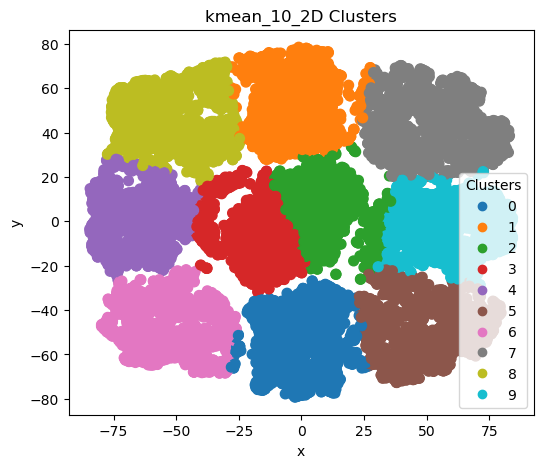

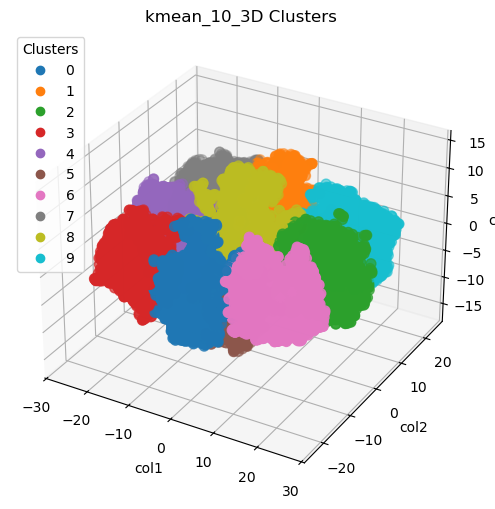

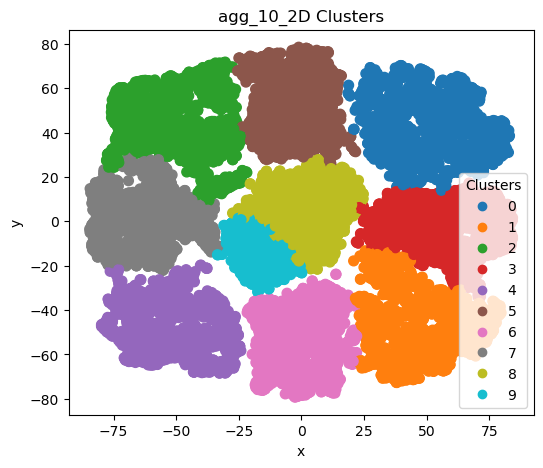

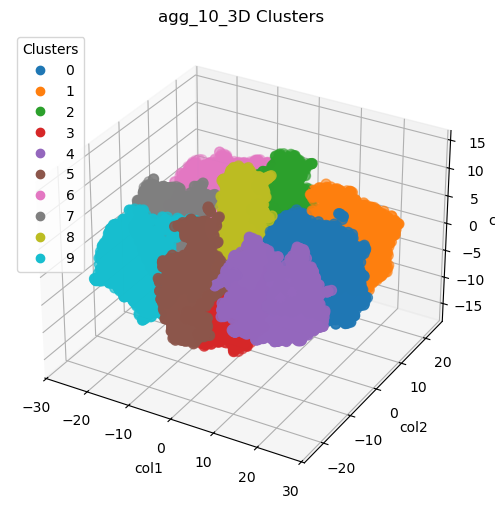

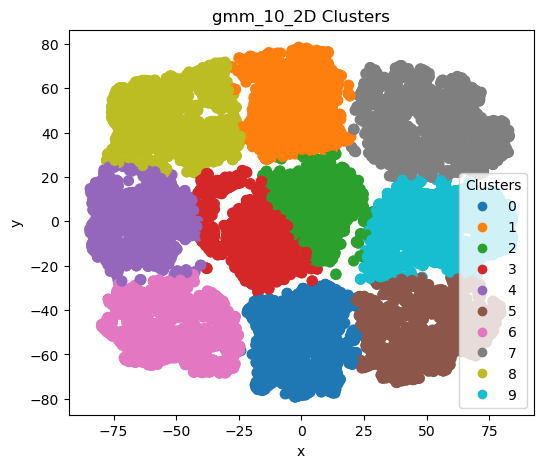

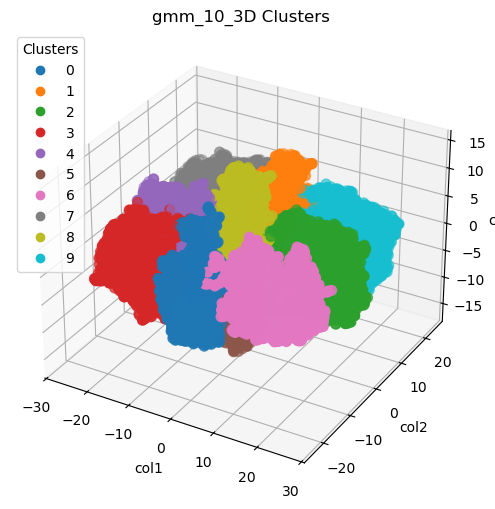

kmean_10_2D		0.7508668447868982		0.4249301850795746
kmean_10_3D		0.9655300146310424		0.35036125779151917
agg_10_2D		0.7825851796767342		0.40022343397140503
agg_10_3D		1.0114239870380735		0.3288447856903076
gmm_10_2D		0.7645278919929522		0.4215109944343567
gmm_10_3D		0.9971788720284535		0.3321138024330139
--------------------------


In [142]:
def plot_clusters_col_3(arr, labels, title):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection="3d")
    scatter = ax.scatter(
        arr[:,0], arr[:,1], arr[:,2],   
        c=labels, cmap="tab10", s=50
    )
    ax.set_xlabel("col1")
    ax.set_ylabel("col2")
    ax.set_zlabel("col3")
    ax.set_title(title)
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.show()

def plot_clusters_col_2(arr, labels, title):
    plt.figure(figsize=(6,5))
    scatter = plt.scatter(arr[:,0], arr[:,1], c=labels, cmap="tab10", s=50)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.show()

def model_evaluateV3(model_names, model_list, tsne_list):
    result_log = dict()
    labels_log = dict()
    
    for name, model in zip(model_names, model_list):
        # Clone to avoid fitting the same model twice
        m1 = clone(model)
        m2 = clone(model)

        m1_name = name + "_2D"
        m2_name = name + "_3D"

        labels_1 = m1.fit_predict(tsne_list[0])   # 2D
        labels_2 = m2.fit_predict(tsne_list[1])   # 3D

        labels_log[m1_name] = labels_1
        labels_log[m2_name] = labels_2
        
        # --- Evaluation ---
        n_clusters_1 = len(set(labels_1)) - (1 if -1 in labels_1 else 0)
        n_clusters_2 = len(set(labels_2)) - (1 if -1 in labels_2 else 0)
        
        if n_clusters_1 > 1:
            db_index_1 = davies_bouldin_score(tsne_list[0], labels_1)
            ss_score_1 = silhouette_score(tsne_list[0], labels_1)
            result_log[m1_name] = [db_index_1, ss_score_1]
        else:
            result_log[m1_name] = ["Not Applicable", "Not Applicable"]
        
        if n_clusters_2 > 1:
            db_index_2 = davies_bouldin_score(tsne_list[1], labels_2)
            ss_score_2 = silhouette_score(tsne_list[1], labels_2)
            result_log[m2_name] = [db_index_2, ss_score_2]
        else:
            result_log[m2_name] = ["Not Applicable", "Not Applicable"]

        # --- Plotting ---
        plot_clusters_col_2(tsne_list[0], labels_1, f"{m1_name} Clusters")
        plot_clusters_col_3(tsne_list[1], labels_2, f"{m2_name} Clusters")
    
    return result_log, labels_log


# Example loop with your cluster_list
cluster_list = [3, 9, 10]
cluster_log_tsne = dict()
labels_log_tsne = dict()

print("Model", "Davies-Bouldin Score","Silhouette Score")

for cluster_num in cluster_list:
    model_kmean_cluster_num = KMeans(n_clusters=cluster_num, init='k-means++', max_iter=300, random_state=42)
    model_agg_cluster_num = AgglomerativeClustering(n_clusters=cluster_num)
    model_gmm_cluster_num = GaussianMixture(n_components=cluster_num, covariance_type='full', random_state=42)

    model_list = [model_kmean_cluster_num, model_agg_cluster_num, model_gmm_cluster_num]
    model_name = [f"kmean_{cluster_num}", f"agg_{cluster_num}", f"gmm_{cluster_num}"]

    result_log_tsne, labels_log = model_evaluateV3(model_name, model_list, tsne_X_data)
    cluster_log_tsne[cluster_num] = result_log_tsne
    labels_log_tsne[cluster_num] = labels_log

    for key, value in result_log_tsne.items():
        print(key, f'{value[0]}', f'{value[1]}', sep="\t\t")

    print("--------------------------")


In [154]:
eps_grid = np.linspace(0.01, 10.0, 50)
min_samples_grid = [3, 5, 7, 10, 15]

best = []
for min_samples in min_samples_grid:
    res = dbscan_eps_scan(tsne_X_data[0], eps_grid, min_samples=min_samples)
    # collect rows where number of clusters >= 2
    for eps, n_clusters, n_noise, frac_noise in res:
        best.append((min_samples, eps, n_clusters, frac_noise))
        print(f"min_samples={min_samples}, eps={eps:.3f}, clusters={n_clusters:2d}, frac_noise={frac_noise:.3f}")
    print()

min_samples=3, eps=0.010, clusters= 0, frac_noise=1.000
min_samples=3, eps=0.214, clusters=468, frac_noise=0.912
min_samples=3, eps=0.418, clusters=1860, frac_noise=0.596
min_samples=3, eps=0.622, clusters=2488, frac_noise=0.297
min_samples=3, eps=0.826, clusters=1987, frac_noise=0.135
min_samples=3, eps=1.029, clusters=1176, frac_noise=0.062
min_samples=3, eps=1.233, clusters=597, frac_noise=0.029
min_samples=3, eps=1.437, clusters=263, frac_noise=0.015
min_samples=3, eps=1.641, clusters=134, frac_noise=0.009
min_samples=3, eps=1.845, clusters=78, frac_noise=0.005
min_samples=3, eps=2.049, clusters=48, frac_noise=0.003
min_samples=3, eps=2.253, clusters=33, frac_noise=0.002
min_samples=3, eps=2.457, clusters=20, frac_noise=0.001
min_samples=3, eps=2.660, clusters=15, frac_noise=0.001
min_samples=3, eps=2.864, clusters=11, frac_noise=0.001
min_samples=3, eps=3.068, clusters=11, frac_noise=0.001
min_samples=3, eps=3.272, clusters= 6, frac_noise=0.001
min_samples=3, eps=3.476, clusters= 

In [156]:
search_cluster = [3,9]
find_result = []
for log in best:
    # print(log)
    if log[-2] in search_cluster:
        find_result.append(log)

find_result

[(5, np.float64(2.660408163265306), 9, np.float64(0.0022727272727272726)),
 (5, np.float64(3.4759183673469387), 3, np.float64(0.000641025641025641)),
 (7, np.float64(2.4565306122448978), 9, np.float64(0.004953379953379953)),
 (7, np.float64(3.2720408163265304), 3, np.float64(0.0016317016317016317)),
 (10, np.float64(3.068163265306122), 3, np.float64(0.003438228438228438)),
 (10, np.float64(3.2720408163265304), 3, np.float64(0.002797202797202797))]

In [144]:
eps_grid = np.linspace(0.01, 100.0, 25)
min_samples_grid = [3, 5, 7, 10, 15]

best = []
for min_samples in min_samples_grid:
    res = dbscan_eps_scan(tsne_X_data[1], eps_grid, min_samples=min_samples)
    # collect rows where number of clusters >= 2
    for eps, n_clusters, n_noise, frac_noise in res:
        best.append((min_samples, eps, n_clusters, frac_noise))
        print(f"min_samples={min_samples}, eps={eps:.3f}, clusters={n_clusters:2d}, frac_noise={frac_noise:.3f}")
    print()

min_samples=3, eps=0.010, clusters= 0, frac_noise=1.000
min_samples=3, eps=4.176, clusters= 1, frac_noise=0.000
min_samples=3, eps=8.342, clusters= 1, frac_noise=0.000
min_samples=3, eps=12.509, clusters= 1, frac_noise=0.000
min_samples=3, eps=16.675, clusters= 1, frac_noise=0.000
min_samples=3, eps=20.841, clusters= 1, frac_noise=0.000
min_samples=3, eps=25.008, clusters= 1, frac_noise=0.000
min_samples=3, eps=29.174, clusters= 1, frac_noise=0.000
min_samples=3, eps=33.340, clusters= 1, frac_noise=0.000
min_samples=3, eps=37.506, clusters= 1, frac_noise=0.000
min_samples=3, eps=41.672, clusters= 1, frac_noise=0.000
min_samples=3, eps=45.839, clusters= 1, frac_noise=0.000
min_samples=3, eps=50.005, clusters= 1, frac_noise=0.000
min_samples=3, eps=54.171, clusters= 1, frac_noise=0.000
min_samples=3, eps=58.337, clusters= 1, frac_noise=0.000
min_samples=3, eps=62.504, clusters= 1, frac_noise=0.000
min_samples=3, eps=66.670, clusters= 1, frac_noise=0.000
min_samples=3, eps=70.836, cluster

In [153]:
search_cluster = [3,9]
find_result = []
for log in best:
    # print(log)
    if log[-2] in search_cluster:
        find_result.append(log)

find_result

[]